# DATA 606 Capstone in Data Science II

Leveraging NLP Predictive Models for Suicide Prevention: A Data-Driven Approach Using Reddit Data

As part of the project titled **"Leveraging NLP Predictive Models for Suicide Prevention: A Data-Driven Approach Using Reddit Data,"** data was sourced from publicly available posts on Reddit, a platform where individuals often express their thoughts and emotions candidly. The data collection focused on posts from mental health-related subreddits such as *r/SuicideWatch*, *r/depression*, and *r/mentalhealth*, which are known to contain content indicative of emotional distress and suicidal ideation.

To provide contrast and ensure "a more balanced dataset", additional posts were extracted from neutral or positive subreddits like *r/AskReddit*, *r/movies*, and *r/happy*. Each post underwent preprocessing steps including text cleaning, normalization, and labeling based on subreddit context and content cues. The final labeled dataset served as the basis for training and evaluating various NLP-based predictive models, with the aim of accurately identifying high-risk individuals and contributing to early intervention efforts in suicide prevention.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
from tabulate import tabulate
from termcolor import colored  
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import GridSearchCV

In [5]:
# Load the first dataset
df1 = pd.read_csv('SuicideWatch_Dataset2.csv')

# Data cleaning for the first dataset
df1 = df1.dropna(subset=["selftext"])
df1 = df1.drop_duplicates(subset=["selftext"]).reset_index(drop=True)

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

df1["cleaned_text"] = df1["selftext"].apply(clean_text)

# Load the second dataset
df2 = pd.read_csv('SuicideWatch_Dataset2_II.csv')

# Data cleaning for the second dataset
df2 = df2.dropna(subset=["selftext"])
df2 = df2.drop_duplicates(subset=["selftext"]).reset_index(drop=True)

# Apply the same text cleaning
df2["cleaned_text"] = df2["selftext"].apply(clean_text)

In [6]:
# Combine both datasets
combined_df = pd.concat([df1, df2]).reset_index(drop=True)

# Verify the combined data
print(combined_df.info())
print(combined_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3296 entries, 0 to 3295
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3296 non-null   object 
 1   title            3296 non-null   object 
 2   selftext         3296 non-null   object 
 3   score            3296 non-null   int64  
 4   num_comments     3296 non-null   int64  
 5   created_utc      3296 non-null   float64
 6   label            1647 non-null   object 
 7   Risk_Level       3296 non-null   object 
 8   Sentiment_Score  3296 non-null   float64
 9   Crisis_Alert     3296 non-null   int64  
 10  cleaned_text     3296 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 283.4+ KB
None
        id                                              title  \
0  1jjq4ni                                            Goodbye   
1  1jjpv91                  I’m not sure what life is anymore   
2  1jjpqwc                     

In [7]:
# Print Summary Statistics
print(colored("Summary Statistics:", 'green'))
print(colored("-----------------------", 'green'))
print(tabulate(combined_df.describe(), headers='keys', tablefmt='pretty'))
print("\n")  # New line for separation

Summary Statistics:
-----------------------
+-------+--------------------+--------------------+--------------------+---------------------+---------------------+
|       |       score        |    num_comments    |    created_utc     |   Sentiment_Score   |    Crisis_Alert     |
+-------+--------------------+--------------------+--------------------+---------------------+---------------------+
| count |       3296.0       |       3296.0       |       3296.0       |       3296.0        |       3296.0        |
| mean  | 104.90321601941747 | 6.970873786407767  | 1740987416.1735437 | 0.06627824635922328 | 0.11286407766990292 |
|  std  | 403.8821565708641  | 16.433368509578933 | 4280500.427446387  | 0.8120389436325084  | 0.31647458796489947 |
|  min  |        0.0         |        0.0         |    1728522852.0    |       -0.9997       |         0.0         |
|  25%  |        2.0         |        1.0         |    1739021717.5    | -0.8720749999999999 |         0.0         |
|  50%  |        5.0

# --- EXPLORATORY DATA ANALYSIS ---

In [8]:
# Checking if the 'created_utc' column exists for feature engineering
if 'created_utc' in combined_df.columns:
    # Convert 'created_utc' to datetime
    combined_df["created_utc"] = pd.to_datetime(combined_df["created_utc"], unit="s")
    
    # Extract features: hour and day_of_week
    combined_df["hour"] = combined_df["created_utc"].dt.hour
    combined_df["day_of_week"] = combined_df["created_utc"].dt.day_name()
else:
    print("'created_utc' column does not exist in the DataFrame, skipping feature engineering.")

# Save the cleaned dataset
try:
    combined_df.to_csv("Cleaned_SuicideWatch_Dataset.csv", index=False)  # Save to CSV without the index
    print("Data cleaned and saved successfully.")
except Exception as e:
    print(f"Error saving the dataset: {e}")

Data cleaned and saved successfully.


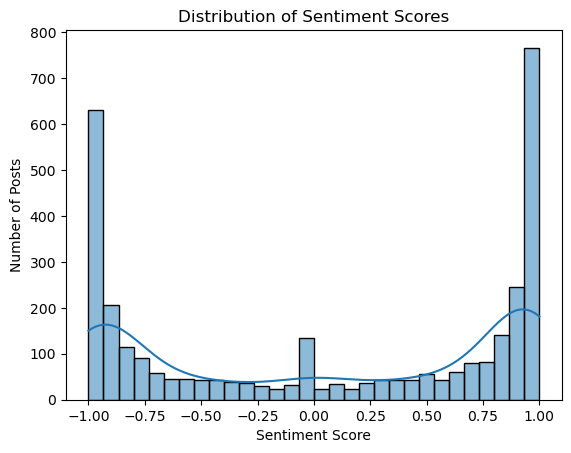

In [9]:
# Distribution of Sentiment Scores
sns.histplot(combined_df["Sentiment_Score"], bins=30, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Posts")
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_16116\1585632086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["Risk_Level"], palette="coolwarm")


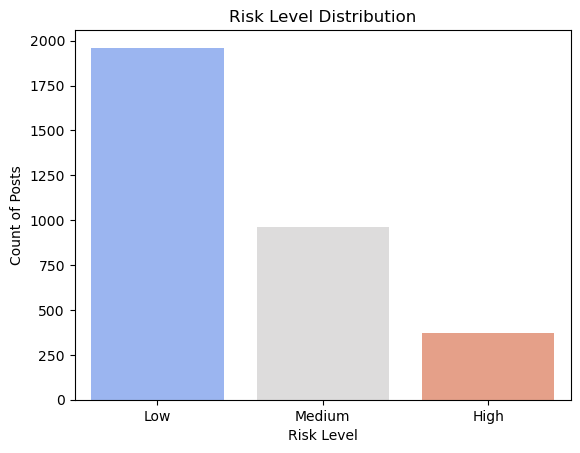

In [10]:
# Risk Level Distribution
sns.countplot(x=combined_df["Risk_Level"], palette="coolwarm")
plt.title("Risk Level Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Count of Posts")
plt.show()

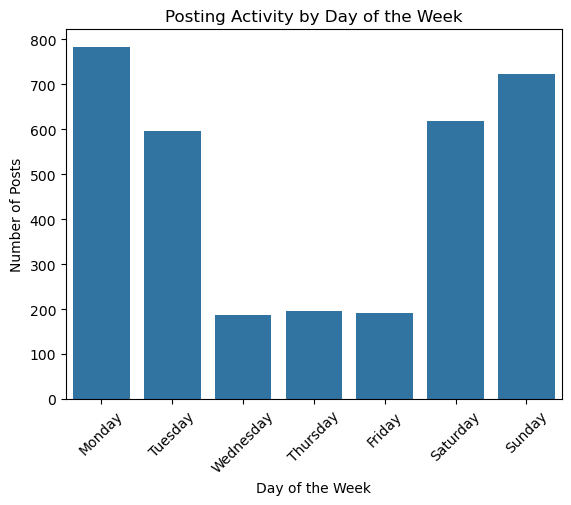

In [11]:
# Posting Activity by Day of Week
sns.countplot(x=combined_df["day_of_week"], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Posting Activity by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.show()

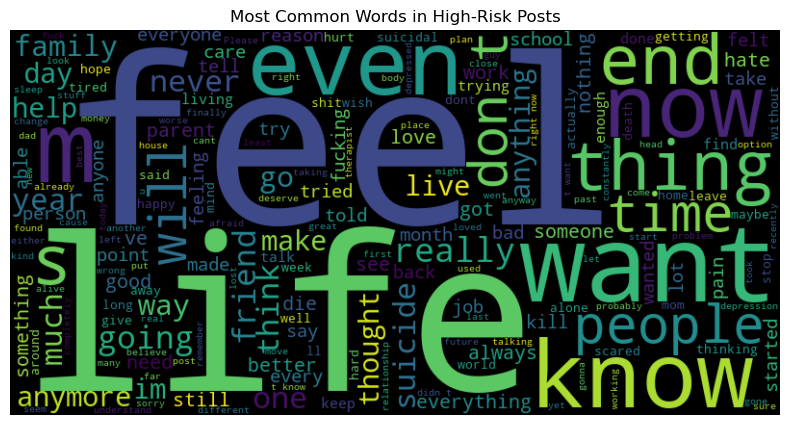

In [12]:
# High-Risk Posts Word Cloud
high_risk_text = " ".join(combined_df[combined_df["Risk_Level"] == "High"]["selftext"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(high_risk_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in High-Risk Posts")
plt.show()

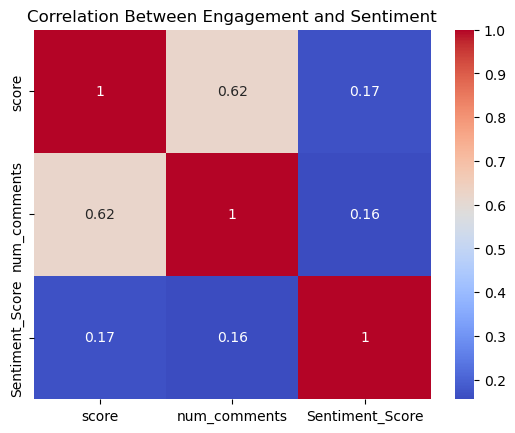

In [13]:
# Correlation Heatmap
sns.heatmap(combined_df[['score', 'num_comments', 'Sentiment_Score']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Engagement and Sentiment")
plt.show()

# NLP with Imbalanced Data:

In natural language processing (NLP) tasks involving imbalanced data, relying solely on accuracy can be misleading. Although accuracy measures overall correctness, it fails to reflect the model’s ability to detect the minority class — the class we usually care most about in sensitive applications like suicide prevention. A model might achieve high accuracy by predominantly predicting the majority class, but this would be ineffective and even dangerous when the minority class contains critical cases.

Instead, precision becomes essential, as it indicates how many of the model’s positive predictions (e.g., identifying high-risk individuals) are actually correct. High precision means fewer false alarms, making the model's alerts more meaningful and trustworthy. On the other hand, recall measures the proportion of actual positive cases the model successfully identifies. In high-stakes contexts like mental health or emergency response, recall is arguably the most critical metric — missing a true high-risk case could have fatal consequences.

The F1 score, which combines precision and recall into a single metric, serves as a balanced measure when both under-alerting and over-alerting must be minimized. It is particularly valuable when there’s a need to maintain sensitivity without triggering an overwhelming number of false positives. Overall, in imbalanced NLP datasets, precision, recall, and F1 score provide a much clearer picture of a model's real-world effectiveness than accuracy alone.

# --- MODELING (I): TRADITIONAL ML ---

The selection of traditional machine learning models such as Logistic Regression, Naive Bayes, and Support Vector Machine (SVM) offers a solid baseline for text classification in NLP projects. Logistic Regression provides interpretability and performs well with linearly separable classes, while Naive Bayes, being probabilistic and fast, is especially effective with high-dimensional sparse data like TF-IDF vectors. SVM excels at capturing complex boundaries between classes and can be highly effective in detecting nuanced patterns in suicide-related language when properly tuned.

On the other hand, Random Forest, Gradient Boosting, and XGBoost bring the power of ensemble learning to traditional models. Random Forest reduces overfitting by aggregating the results of multiple decision trees, offering robustness and better generalization. Gradient Boosting and XGBoost iteratively improve their predictions by learning from prior errors, making them well-suited for identifying subtle linguistic cues in imbalanced datasets. These models provide a strong foundation for benchmarking the performance of more advanced deep learning and ensemble approaches in suicide prevention tasks using NLP.

In [14]:
# Prepare data for modeling
X = combined_df['cleaned_text']
y = combined_df['Risk_Level']

# Encode the target variable if it contains string labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert string labels to numeric

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)  # Transform text data to numeric

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

C:\Users\phili\AppData\Local\Temp\ipykernel_16116\602060932.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


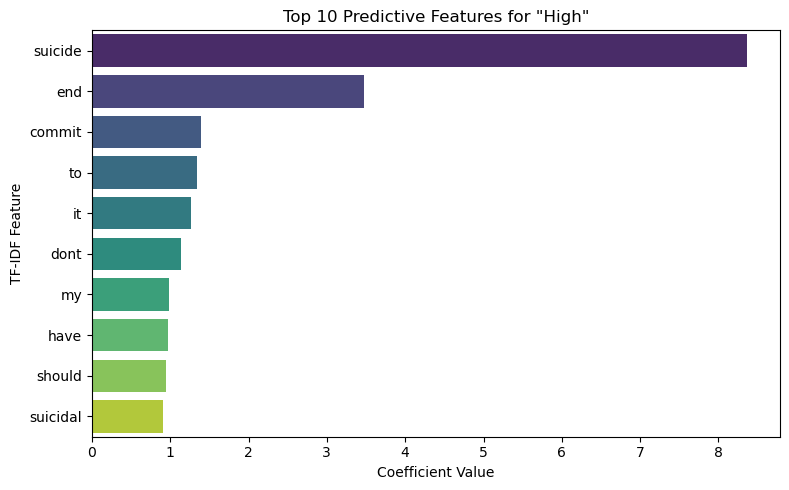

C:\Users\phili\AppData\Local\Temp\ipykernel_16116\602060932.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


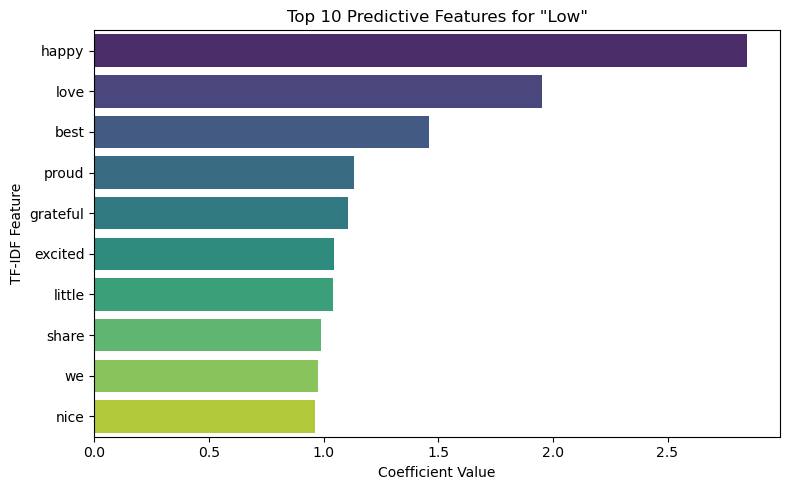

C:\Users\phili\AppData\Local\Temp\ipykernel_16116\602060932.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


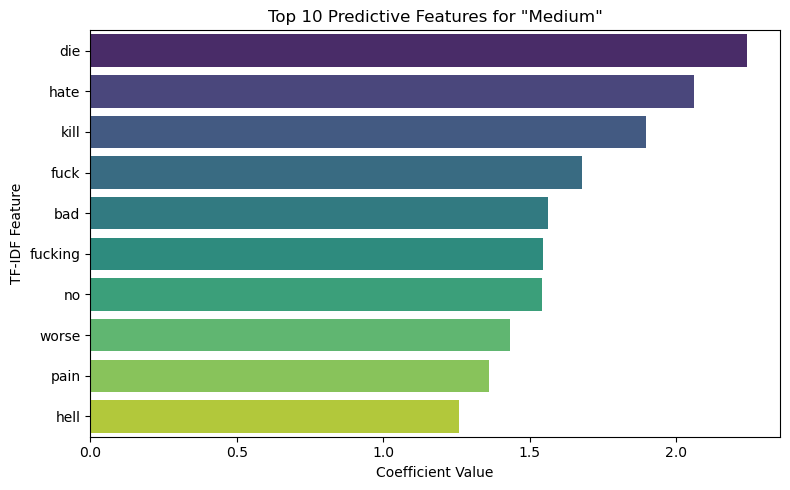

In [15]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust if needed
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# --- Train Logistic Regression ---
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# --- Extract Feature Importance ---
feature_names = vectorizer.get_feature_names_out()
coef_matrix = lr.coef_  # shape: (n_classes, n_features)

# Plot top N features per class
top_n = 10
for idx, class_label in enumerate(class_names):
    class_coefs = coef_matrix[idx]
    top_indices = class_coefs.argsort()[-top_n:][::-1]  # Top positive features

    top_features = pd.DataFrame({
        'Feature': feature_names[top_indices],
        'Importance': class_coefs[top_indices]
    })

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top {top_n} Predictive Features for "{class_label}"')
    plt.xlabel('Coefficient Value')
    plt.ylabel('TF-IDF Feature')
    plt.tight_layout()
    plt.show()

# --- MODELING (I): TRAINING & TESTING ON DIFFERENT TARGETS ---

In [16]:
# Step 1: Prepare data
X = combined_df['cleaned_text']

# Encode 'Risk_Level' as overall target
label_encoder = LabelEncoder()
y_overall = label_encoder.fit_transform(combined_df['Risk_Level'])

# Create binary targets for Low, Medium, and High Risk detection
combined_df['Low_Risk_Binary'] = (combined_df['Risk_Level'] == 'Low').astype(int)
combined_df['Medium_Risk_Binary'] = (combined_df['Risk_Level'] == 'Medium').astype(int)
combined_df['High_Risk_Binary'] = (combined_df['Risk_Level'] == 'High').astype(int)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Function to define models based on task type
def get_models(task_type="multi"):
    if task_type == "multi":
        return {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Naive Bayes': MultinomialNB(),
            'Support Vector Machine': SVC(),
            'Random Forest': RandomForestClassifier(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
        }
    else:  # binary
        return {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Naive Bayes': MultinomialNB(),
            'Support Vector Machine': SVC(probability=True),
            'Random Forest': RandomForestClassifier(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'XGBoost': XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
        }

# Helper function to train and evaluate models
def train_and_evaluate(X, y, description="", task_type="multi"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    models = get_models(task_type)
    results = {}
    
    print(colored(f"\n--- {description} ---", 'cyan'))
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        results[name] = {
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'train_report': classification_report(y_train, y_train_pred, output_dict=True),
            'test_report': classification_report(y_test, y_test_pred, output_dict=True),
            'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
            'test_conf_matrix': confusion_matrix(y_test, y_test_pred)
        }
        
        # Print performance
        print(f"\nModel: {name}")
        print(f"Training Accuracy: {results[name]['train_accuracy']:.4f}")
        print(f"Testing Accuracy: {results[name]['test_accuracy']:.4f}")
        print("\nTraining Classification Report:")
        print(classification_report(y_train, y_train_pred))
        print("\nTesting Classification Report:")
        print(classification_report(y_test, y_test_pred))
    
    return results

# Step 2: Train and evaluate on overall risk level (multi-class classification)
overall_results = train_and_evaluate(
    X_tfidf, 
    y_overall, 
    description="Overall Risk Level (Multi-class Classification)", 
    task_type="multi"
)

# Step 3: Train and evaluate on Low Risk detection (binary classification)
low_risk_results = train_and_evaluate(
    X_tfidf, 
    combined_df['Low_Risk_Binary'], 
    description="Low Risk Detection (Binary Classification)", 
    task_type="binary"
)

# Step 4: Train and evaluate on Medium Risk detection (binary classification)
medium_risk_results = train_and_evaluate(
    X_tfidf, 
    combined_df['Medium_Risk_Binary'], 
    description="Medium Risk Detection (Binary Classification)", 
    task_type="binary"
)

# Step 5: Train and evaluate on High Risk detection (binary classification)
high_risk_results = train_and_evaluate(
    X_tfidf, 
    combined_df['High_Risk_Binary'], 
    description="High Risk Detection (Binary Classification)", 
    task_type="binary"
)


--- Overall Risk Level (Multi-class Classification) ---

Model: Logistic Regression
Training Accuracy: 0.9040
Testing Accuracy: 0.7864

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       303
           1       0.91      0.97      0.94      1582
           2       0.87      0.87      0.87       751

    accuracy                           0.90      2636
   macro avg       0.92      0.83      0.86      2636
weighted avg       0.91      0.90      0.90      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.43      0.58        69
           1       0.80      0.91      0.85       379
           2       0.75      0.68      0.71       212

    accuracy                           0.79       660
   macro avg       0.80      0.67      0.71       660
weighted avg       0.79      0.79      0.78       660


Model: Naive Bayes
Training Accuracy

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
Training Accuracy: 0.9996
Testing Accuracy: 0.8273

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00      1582
           2       1.00      1.00      1.00       751

    accuracy                           1.00      2636
   macro avg       1.00      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        69
           1       0.86      0.87      0.87       379
           2       0.74      0.75      0.75       212

    accuracy                           0.83       660
   macro avg       0.84      0.81      0.82       660
weighted avg       0.83      0.83      0.83       660


--- Low Risk Detection (Binary Classification) ---

Model: Logistic Regression
Training Accuracy: 0.9063


C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
Training Accuracy: 0.9981
Testing Accuracy: 0.8348

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1054
           1       1.00      1.00      1.00      1582

    accuracy                           1.00      2636
   macro avg       1.00      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       281
           1       0.86      0.85      0.86       379

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.84      0.83      0.83       660


--- Medium Risk Detection (Binary Classification) ---

Model: Logistic Regression
Training Accuracy: 0.8631
Testing Accuracy: 0.7970

Training Classification Report:
              precision    recall  f1-score   s

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
Training Accuracy: 0.9981
Testing Accuracy: 0.8167

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1885
           1       1.00      0.99      1.00       751

    accuracy                           1.00      2636
   macro avg       1.00      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       448
           1       0.75      0.64      0.69       212

    accuracy                           0.82       660
   macro avg       0.80      0.77      0.78       660
weighted avg       0.81      0.82      0.81       660


--- High Risk Detection (Binary Classification) ---

Model: Logistic Regression
Training Accuracy: 0.9025
Testing Accuracy: 0.9076

Training Classification Report:
              precision    recall  f1-score   sup

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
Training Accuracy: 1.0000
Testing Accuracy: 0.9818

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2333
           1       1.00      1.00      1.00       303

    accuracy                           1.00      2636
   macro avg       1.00      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       591
           1       0.94      0.88      0.91        69

    accuracy                           0.98       660
   macro avg       0.96      0.94      0.95       660
weighted avg       0.98      0.98      0.98       660



# --- MODEL COMPARISON: TRADITIONAL ML ---

# --Overall Traditional ML Models Comparison--

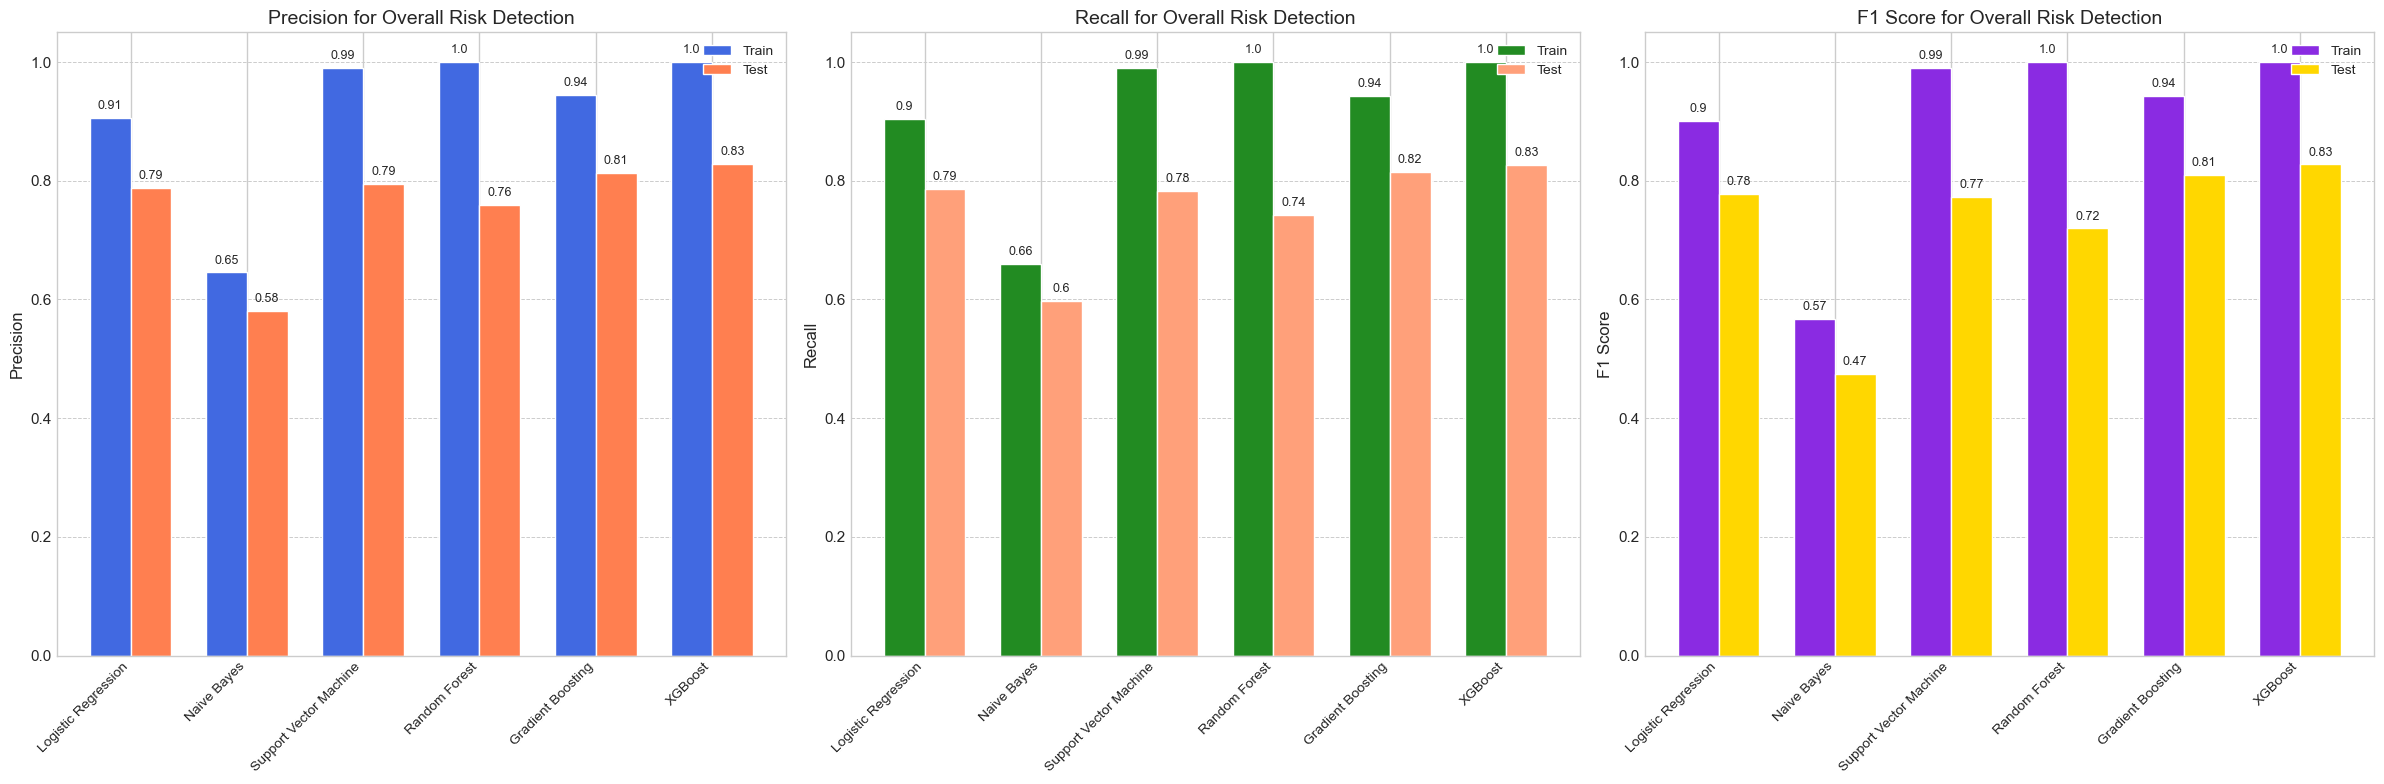

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Correct extract_metrics function for both train and test
def extract_metrics(results_dict, report_type='train_report'):
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    
    for model_name, metrics in results_dict.items():
        report = metrics[report_type]
        precision_scores[model_name] = report['weighted avg']['precision']
        recall_scores[model_name] = report['weighted avg']['recall']
        f1_scores[model_name] = report['weighted avg']['f1-score']
    
    return precision_scores, recall_scores, f1_scores

# Extract metrics for overall risk level
overall_precision_train, overall_recall_train, overall_f1_train = extract_metrics(overall_results, report_type='train_report')
overall_precision_test, overall_recall_test, overall_f1_test = extract_metrics(overall_results, report_type='test_report')

# Create DataFrame for overall risk level
overall_risk_df = pd.DataFrame({
    'Model': list(overall_precision_train.keys()),
    'Precision (Train)': list(overall_precision_train.values()),
    'Recall (Train)': list(overall_recall_train.values()),
    'F1 Score (Train)': list(overall_f1_train.values()),
    'Precision (Test)': list(overall_precision_test.values()),
    'Recall (Test)': list(overall_recall_test.values()),
    'F1 Score (Test)': list(overall_f1_test.values())
})

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
colors = ['royalblue', 'coral', 'forestgreen', 'lightsalmon', 'blueviolet', 'gold']

# Plot for Precision
x = np.arange(len(overall_risk_df['Model']))
width = 0.35

bars1 = ax[0].bar(x - width/2, overall_risk_df['Precision (Train)'], width, label='Train', color=colors[0])
bars2 = ax[0].bar(x + width/2, overall_risk_df['Precision (Test)'], width, label='Test', color=colors[1])
ax[0].set_title('Precision for Overall Risk Detection', fontsize=14, fontfamily='sans-serif')
ax[0].set_ylabel('Precision', fontsize=12, fontfamily='sans-serif')
ax[0].set_xticks(x)
ax[0].set_xticklabels(overall_risk_df['Model'], rotation=45, ha='right', fontsize=10, fontfamily='sans-serif')
ax[0].legend(loc='upper right', fontsize=10)
ax[0].grid(axis='y', linestyle='--', linewidth=0.7)

# Add values on top of bars for Precision
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), 
               ha='center', va='bottom', fontsize=9, fontfamily='sans-serif')

# Plot for Recall
bars3 = ax[1].bar(x - width/2, overall_risk_df['Recall (Train)'], width, label='Train', color=colors[2])
bars4 = ax[1].bar(x + width/2, overall_risk_df['Recall (Test)'], width, label='Test', color=colors[3])
ax[1].set_title('Recall for Overall Risk Detection', fontsize=14, fontfamily='sans-serif')
ax[1].set_ylabel('Recall', fontsize=12, fontfamily='sans-serif')
ax[1].set_xticks(x)
ax[1].set_xticklabels(overall_risk_df['Model'], rotation=45, ha='right', fontsize=10, fontfamily='sans-serif')
ax[1].legend(loc='upper right', fontsize=10)
ax[1].grid(axis='y', linestyle='--', linewidth=0.7)

# Add values on top of bars for Recall
for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), 
               ha='center', va='bottom', fontsize=9, fontfamily='sans-serif')

# Plot for F1 Score
bars5 = ax[2].bar(x - width/2, overall_risk_df['F1 Score (Train)'], width, label='Train', color=colors[4])
bars6 = ax[2].bar(x + width/2, overall_risk_df['F1 Score (Test)'], width, label='Test', color=colors[5])
ax[2].set_title('F1 Score for Overall Risk Detection', fontsize=14, fontfamily='sans-serif')
ax[2].set_ylabel('F1 Score', fontsize=12, fontfamily='sans-serif')
ax[2].set_xticks(x)
ax[2].set_xticklabels(overall_risk_df['Model'], rotation=45, ha='right', fontsize=10, fontfamily='sans-serif')
ax[2].legend(loc='upper right', fontsize=10)
ax[2].grid(axis='y', linestyle='--', linewidth=0.7)

# Add values on top of bars for F1 Score
for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), 
               ha='center', va='bottom', fontsize=9, fontfamily='sans-serif')

# Adjust layout
plt.tight_layout()
plt.show()

## --Low Risk Levels Traditional ML Model Comparison--

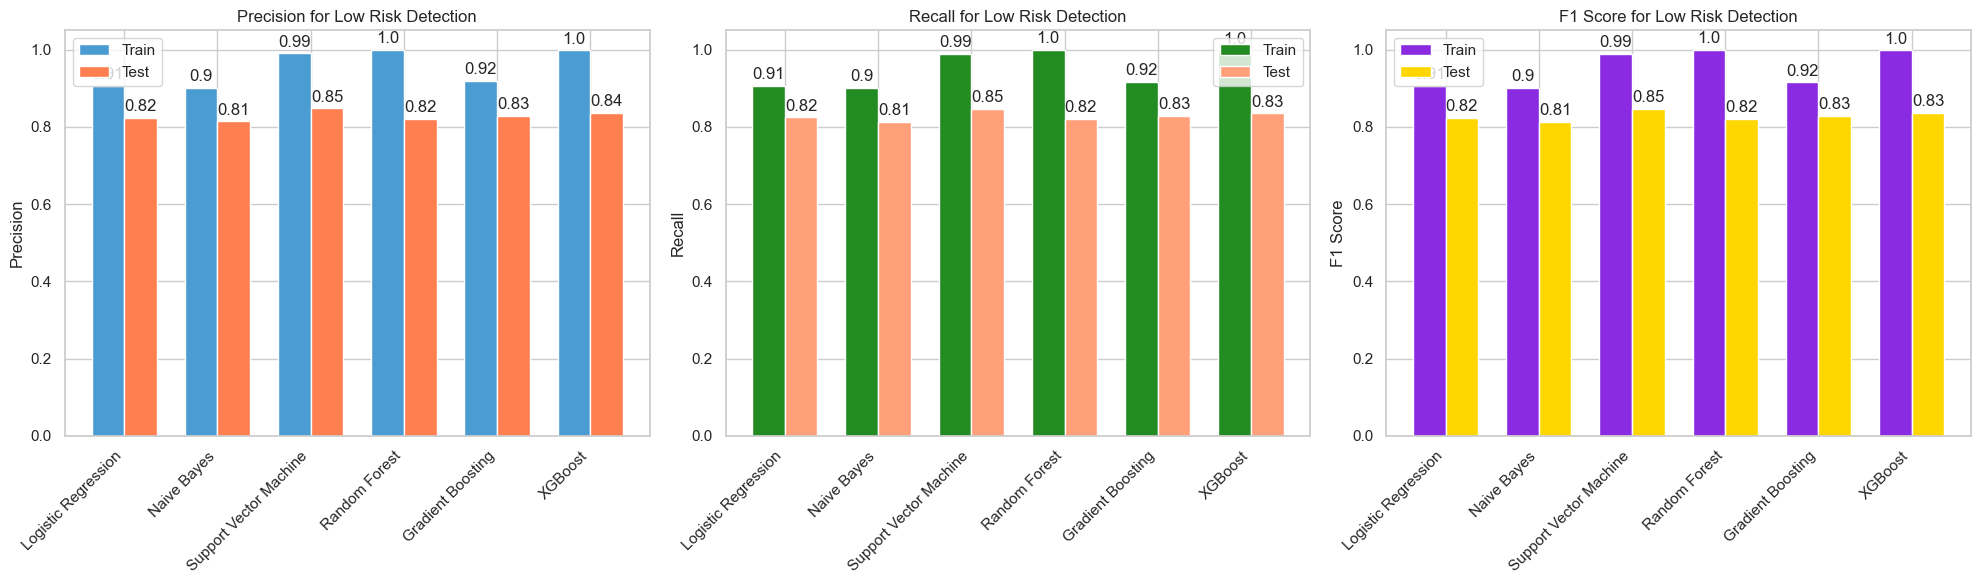

In [30]:
# Correct extract_metrics function
def extract_metrics(results_dict, report_type='train_report'):
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    
    for model_name, metrics in results_dict.items():
        report = metrics[report_type]
        precision_scores[model_name] = report['weighted avg']['precision']
        recall_scores[model_name] = report['weighted avg']['recall']
        f1_scores[model_name] = report['weighted avg']['f1-score']
    
    return precision_scores, recall_scores, f1_scores

# Extract for train and test separately
low_precision_train, low_recall_train, low_f1_train = extract_metrics(low_risk_results, report_type='train_report')
low_precision_test, low_recall_test, low_f1_test = extract_metrics(low_risk_results, report_type='test_report')

# Create DataFrame
low_risk_df = pd.DataFrame({
    'Model': list(low_precision_train.keys()),
    'Precision (Train)': list(low_precision_train.values()),
    'Recall (Train)': list(low_recall_train.values()),
    'F1 Score (Train)': list(low_f1_train.values()),
    'Precision (Test)': list(low_precision_test.values()),
    'Recall (Test)': list(low_recall_test.values()),
    'F1 Score (Test)': list(low_f1_test.values())
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

x = np.arange(len(low_risk_df['Model']))  # label locations
width = 0.35  # width of the bars

# Precision
bars1 = ax[0].bar(x - width/2, low_risk_df['Precision (Train)'], width, label='Train', color='#4B9CD3')  # royal blue
bars2 = ax[0].bar(x + width/2, low_risk_df['Precision (Test)'], width, label='Test', color='#FF7F50')  # coral
ax[0].set_title('Precision for Low Risk Detection')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(low_risk_df['Model'], rotation=45, ha='right')
ax[0].legend()

# Add values on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Recall
bars3 = ax[1].bar(x - width/2, low_risk_df['Recall (Train)'], width, label='Train', color='#228B22')  # forest green
bars4 = ax[1].bar(x + width/2, low_risk_df['Recall (Test)'], width, label='Test', color='#FFA07A')  # light salmon
ax[1].set_title('Recall for Low Risk Detection')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(low_risk_df['Model'], rotation=45, ha='right')
ax[1].legend()

# Add values on top of bars
for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# F1 Score
bars5 = ax[2].bar(x - width/2, low_risk_df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')  # blue violet
bars6 = ax[2].bar(x + width/2, low_risk_df['F1 Score (Test)'], width, label='Test', color='#FFD700')  # gold
ax[2].set_title('F1 Score for Low Risk Detection')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(low_risk_df['Model'], rotation=45, ha='right')
ax[2].legend()

# Add values on top of bars
for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## --Medium Risk Levels Traditional ML Model Comparison--

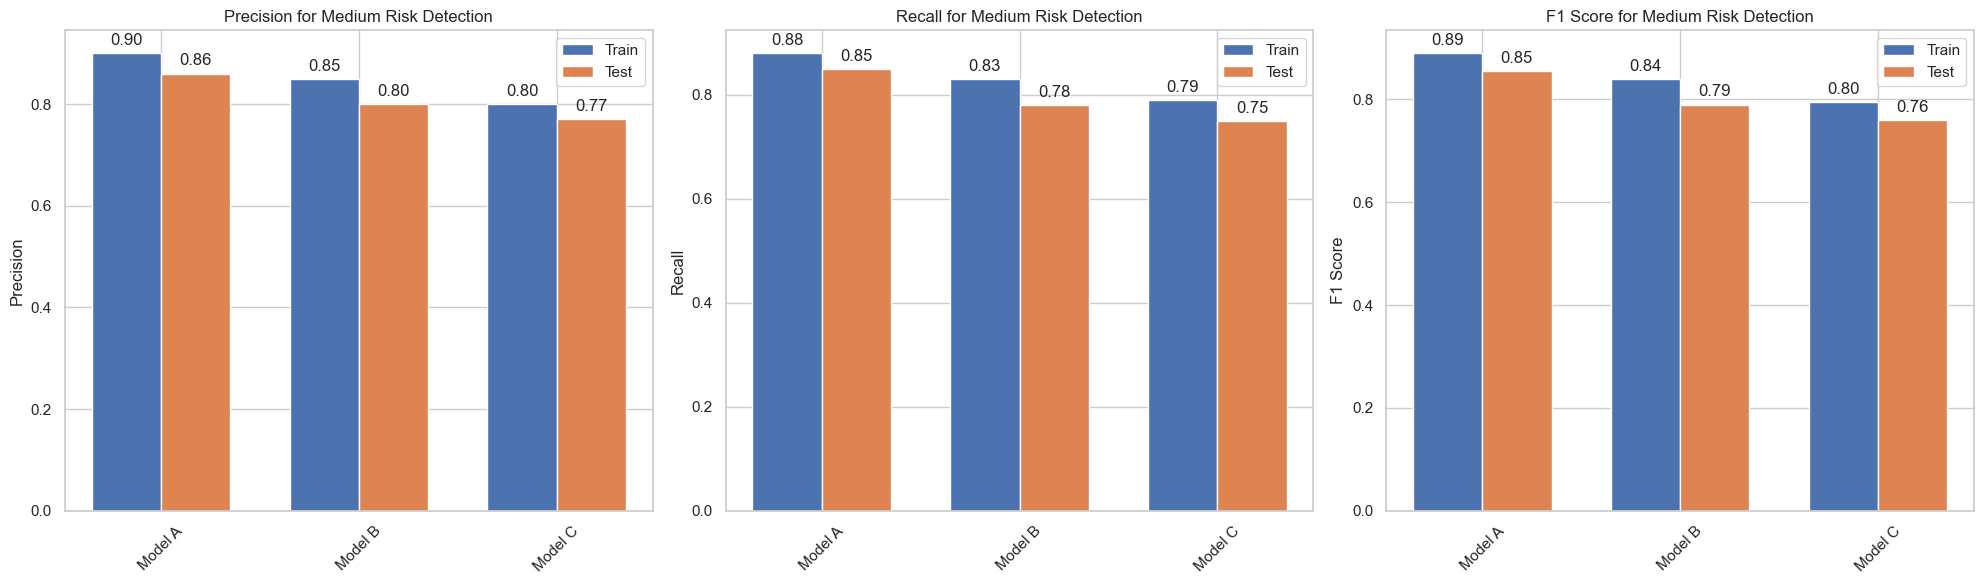

In [43]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example dummy data
medium_risk_df = pd.DataFrame({
    'Model': ['Model A', 'Model B', 'Model C'],
    'Precision (Train)': [0.9, 0.85, 0.8],
    'Recall (Train)': [0.88, 0.83, 0.79],
    'F1 Score (Train)': [0.89, 0.84, 0.795],
    'Precision (Test)': [0.86, 0.8, 0.77],
    'Recall (Test)': [0.85, 0.78, 0.75],
    'F1 Score (Test)': [0.855, 0.79, 0.76]
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
x = np.arange(len(medium_risk_df['Model']))  # label locations
width = 0.35

# Precision plot
bars1 = ax[0].bar(x - width/2, medium_risk_df['Precision (Train)'], width, label='Train')
bars2 = ax[0].bar(x + width/2, medium_risk_df['Precision (Test)'], width, label='Test')
ax[0].set_title('Precision for Medium Risk Detection')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(medium_risk_df['Model'], rotation=45)
ax[0].legend()

for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Recall plot
bars3 = ax[1].bar(x - width/2, medium_risk_df['Recall (Train)'], width, label='Train')
bars4 = ax[1].bar(x + width/2, medium_risk_df['Recall (Test)'], width, label='Test')
ax[1].set_title('Recall for Medium Risk Detection')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(medium_risk_df['Model'], rotation=45)
ax[1].legend()

for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# F1 plot
bars5 = ax[2].bar(x - width/2, medium_risk_df['F1 Score (Train)'], width, label='Train')
bars6 = ax[2].bar(x + width/2, medium_risk_df['F1 Score (Test)'], width, label='Test')
ax[2].set_title('F1 Score for Medium Risk Detection')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(medium_risk_df['Model'], rotation=45)
ax[2].legend()

for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


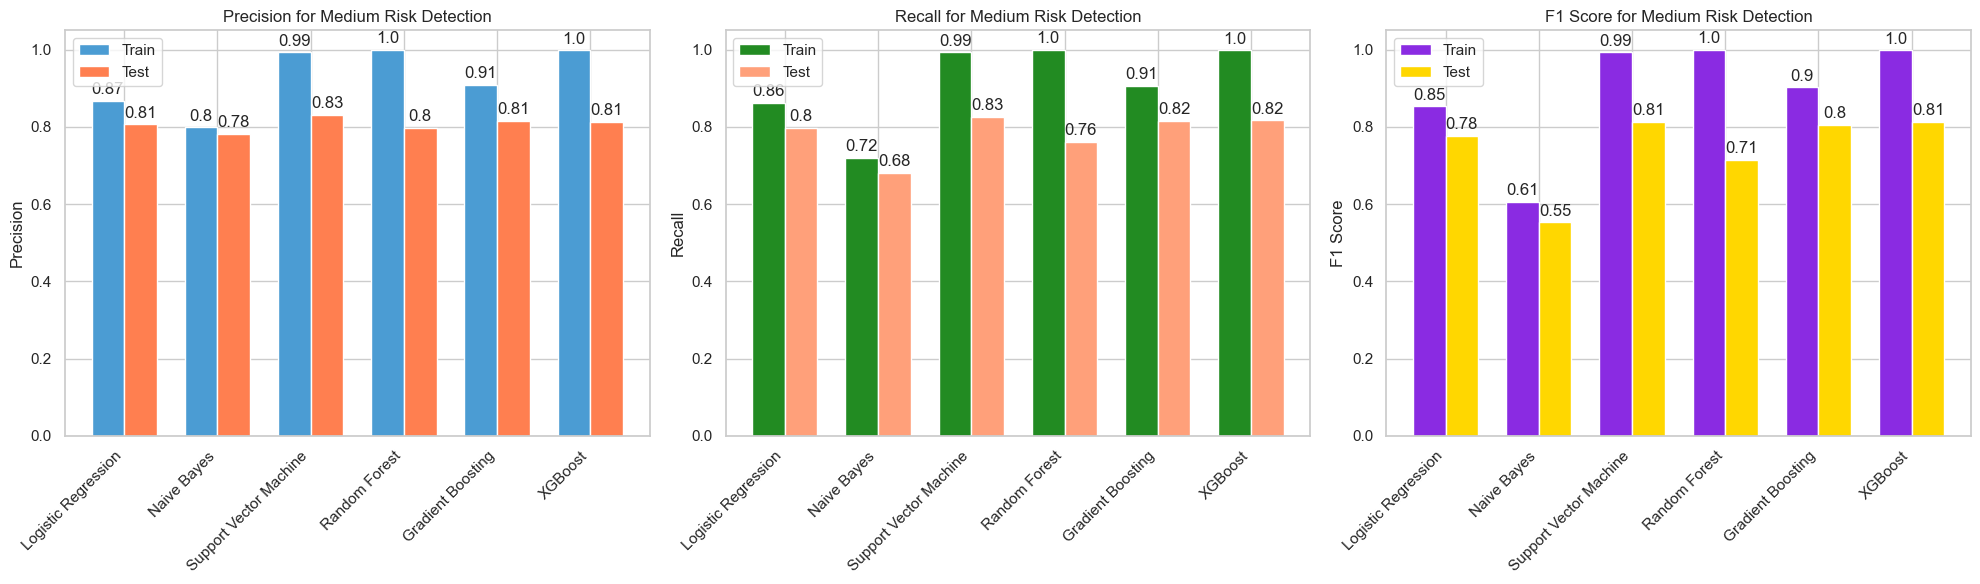

In [44]:
# Correct extract_metrics function
def extract_metrics(results_dict, report_type='train_report'):
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    
    for model_name, metrics in results_dict.items():
        report = metrics[report_type]
        precision_scores[model_name] = report['weighted avg']['precision']
        recall_scores[model_name] = report['weighted avg']['recall']
        f1_scores[model_name] = report['weighted avg']['f1-score']
    
    return precision_scores, recall_scores, f1_scores

# Extract for train and test separately
medium_precision_train, medium_recall_train, medium_f1_train = extract_metrics(medium_risk_results, report_type='train_report')
medium_precision_test, medium_recall_test, medium_f1_test = extract_metrics(medium_risk_results, report_type='test_report')

# Create DataFrame
medium_risk_df = pd.DataFrame({
    'Model': list(medium_precision_train.keys()),
    'Precision (Train)': list(medium_precision_train.values()),
    'Recall (Train)': list(medium_recall_train.values()),
    'F1 Score (Train)': list(medium_f1_train.values()),
    'Precision (Test)': list(medium_precision_test.values()),
    'Recall (Test)': list(medium_recall_test.values()),
    'F1 Score (Test)': list(medium_f1_test.values())
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

x = np.arange(len(medium_risk_df['Model']))  # label locations
width = 0.35  # width of the bars

# Precision
bars1 = ax[0].bar(x - width/2, medium_risk_df['Precision (Train)'], width, label='Train', color='#4B9CD3')
bars2 = ax[0].bar(x + width/2, medium_risk_df['Precision (Test)'], width, label='Test', color='#FF7F50')
ax[0].set_title('Precision for Medium Risk Detection')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(medium_risk_df['Model'], rotation=45, ha='right')
ax[0].legend()

# Add values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Recall
bars3 = ax[1].bar(x - width/2, medium_risk_df['Recall (Train)'], width, label='Train', color='#228B22')
bars4 = ax[1].bar(x + width/2, medium_risk_df['Recall (Test)'], width, label='Test', color='#FFA07A')
ax[1].set_title('Recall for Medium Risk Detection')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(medium_risk_df['Model'], rotation=45, ha='right')
ax[1].legend()

for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# F1 Score
bars5 = ax[2].bar(x - width/2, medium_risk_df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')
bars6 = ax[2].bar(x + width/2, medium_risk_df['F1 Score (Test)'], width, label='Test', color='#FFD700')
ax[2].set_title('F1 Score for Medium Risk Detection')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(medium_risk_df['Model'], rotation=45, ha='right')
ax[2].legend()

for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## --High Risk Levels Traditional ML Model Comparison--

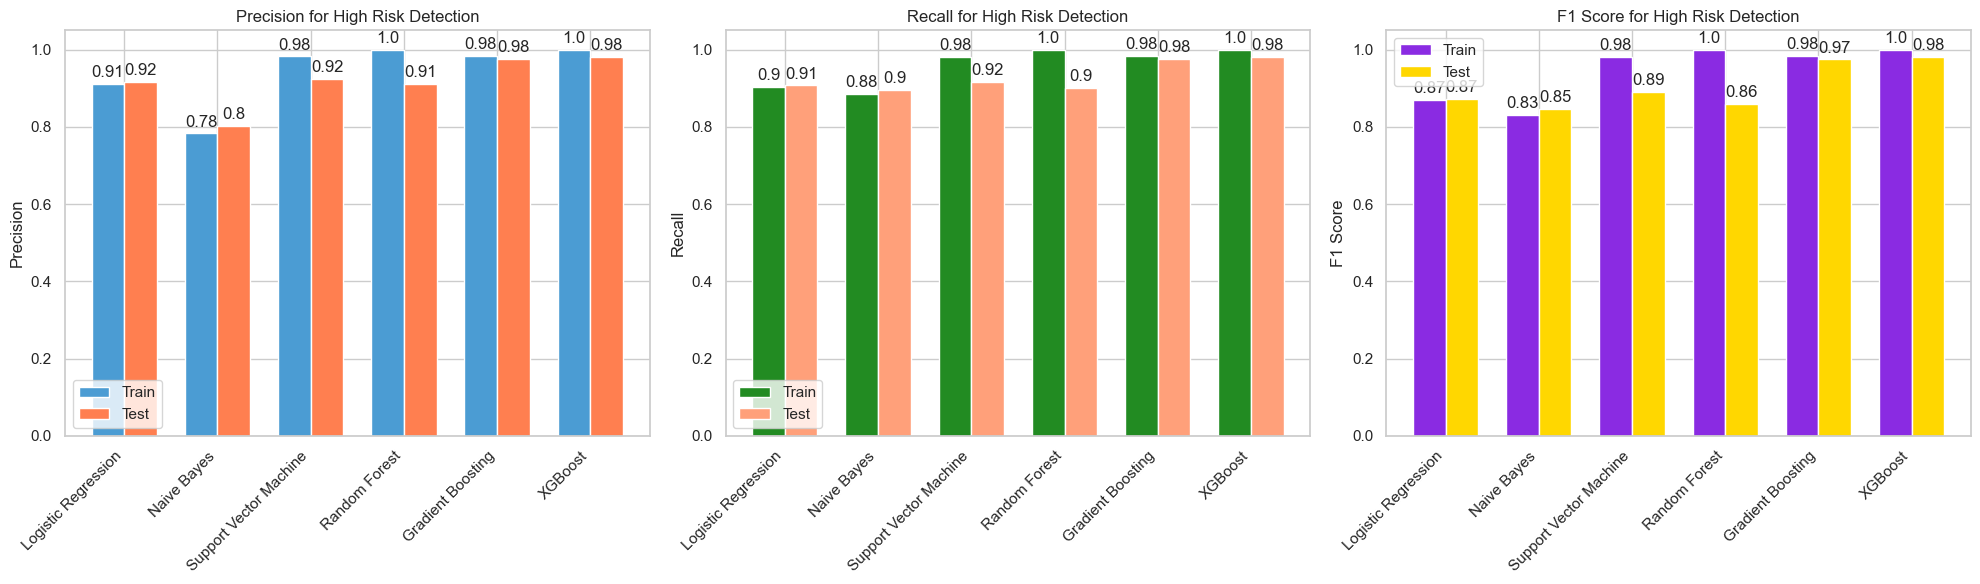

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Corrected extract_metrics function
def extract_metrics(results_dict, report_type='train_report'):
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    
    for model_name, metrics in results_dict.items():
        report = metrics[report_type]
        precision_scores[model_name] = report['weighted avg']['precision']
        recall_scores[model_name] = report['weighted avg']['recall']
        f1_scores[model_name] = report['weighted avg']['f1-score']
    
    return precision_scores, recall_scores, f1_scores

# Extract metrics for high-risk models
high_precision_train, high_recall_train, high_f1_train = extract_metrics(high_risk_results, report_type='train_report')
high_precision_test, high_recall_test, high_f1_test = extract_metrics(high_risk_results, report_type='test_report')

# Create DataFrame for high-risk models
high_risk_df = pd.DataFrame({
    'Model': list(high_precision_train.keys()),
    'Precision (Train)': list(high_precision_train.values()),
    'Recall (Train)': list(high_recall_train.values()),
    'F1 Score (Train)': list(high_f1_train.values()),
    'Precision (Test)': list(high_precision_test.values()),
    'Recall (Test)': list(high_recall_test.values()),
    'F1 Score (Test)': list(high_f1_test.values())
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

x = np.arange(len(high_risk_df['Model']))  # label locations
width = 0.35  # width of the bars

# Precision
bars1 = ax[0].bar(x - width/2, high_risk_df['Precision (Train)'], width, label='Train', color='#4B9CD3')
bars2 = ax[0].bar(x + width/2, high_risk_df['Precision (Test)'], width, label='Test', color='#FF7F50')
ax[0].set_title('Precision for High Risk Detection')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(high_risk_df['Model'], rotation=45, ha='right')
ax[0].legend()

# Add values on bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Recall
bars3 = ax[1].bar(x - width/2, high_risk_df['Recall (Train)'], width, label='Train', color='#228B22')
bars4 = ax[1].bar(x + width/2, high_risk_df['Recall (Test)'], width, label='Test', color='#FFA07A')
ax[1].set_title('Recall for High Risk Detection')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(high_risk_df['Model'], rotation=45, ha='right')
ax[1].legend()

for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# F1 Score
bars5 = ax[2].bar(x - width/2, high_risk_df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')
bars6 = ax[2].bar(x + width/2, high_risk_df['F1 Score (Test)'], width, label='Test', color='#FFD700')
ax[2].set_title('F1 Score for High Risk Detection')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(high_risk_df['Model'], rotation=45, ha='right')
ax[2].legend()

for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Final layout
plt.tight_layout()
plt.show()


In the suicide prevention project, different models were tested to predict overall risk levels and binary categories. **Gradient Boosting** performed best for overall risk level classification, achieving an F1-score of 81%, providing a balanced approach despite the data imbalance. For **low-risk detection**, **XGBoost** excelled with an F1-score of 83%, effectively distinguishing low-risk from high-risk individuals while minimizing false positives.

For **medium-risk detection**, **Logistic Regression** achieved the highest F1-score, particularly performing well for low-risk individuals, although it struggled with recall for the medium-risk class. For **high-risk detection**, **Logistic Regression** again stood out due to its high recall of 83%, being highly sensitive in detecting high-risk individuals and minimizing false negatives, despite lower precision.

# ROC Curves

# Micro-Averaged ROC Curves for Multiclass Models

Micro-averaged ROC curves are invaluable for assessing overall model performance across all classes, offering a high-level summary that facilitates model comparison and selection. They are particularly advantageous when dealing with class imbalance, as they ensure each instance contributes equally to the evaluation metric, regardless of its class. However, they do not provide insights into the performance of individual classes.

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\phili\anaconda3\Lib\site-packages\

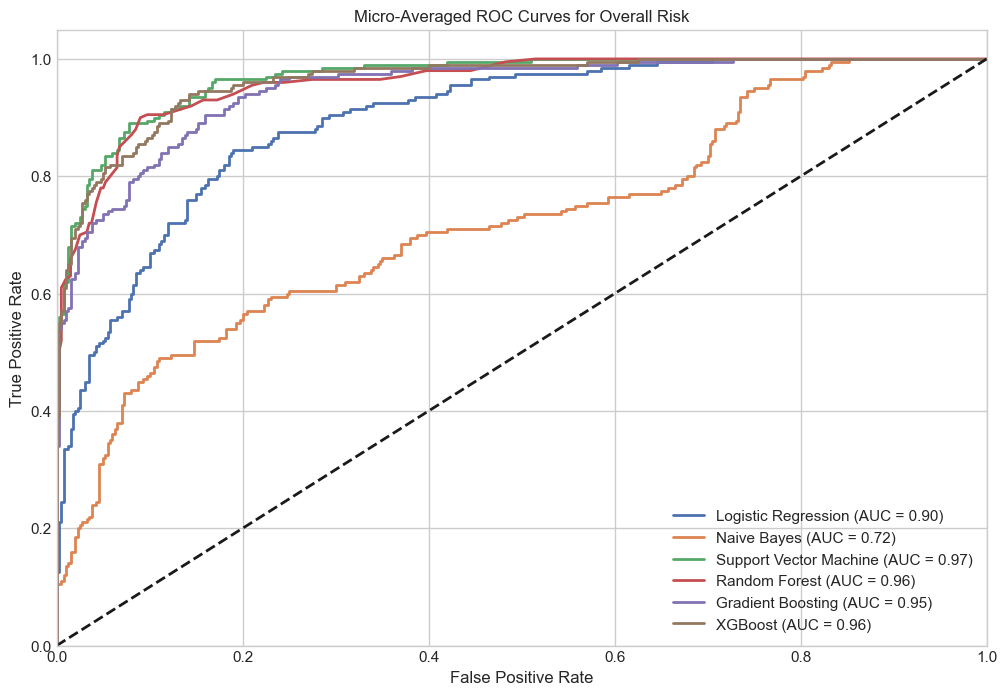

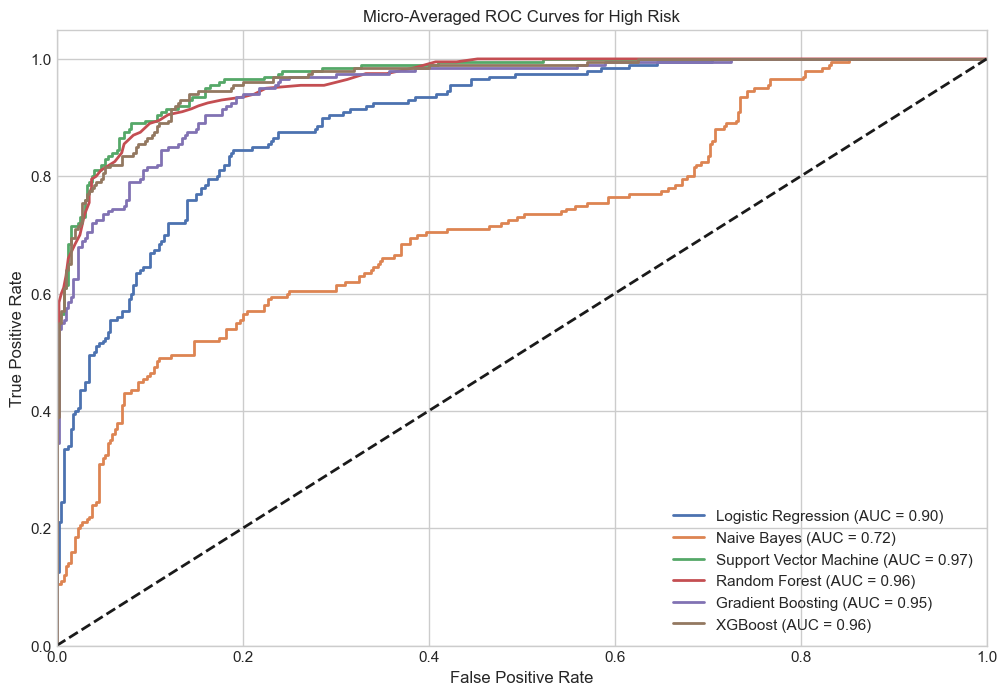

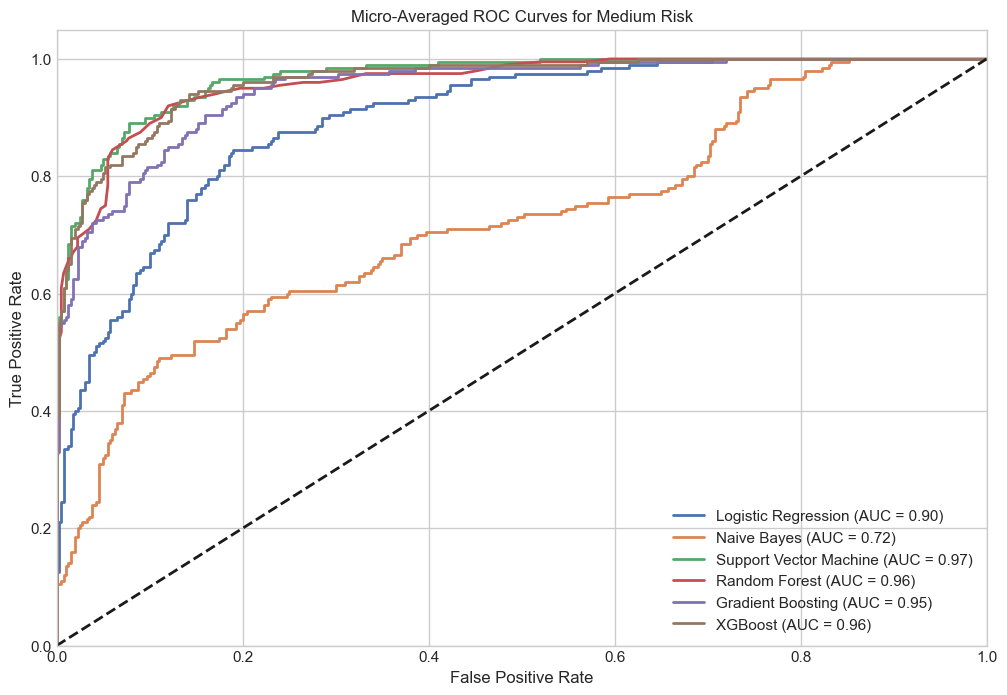

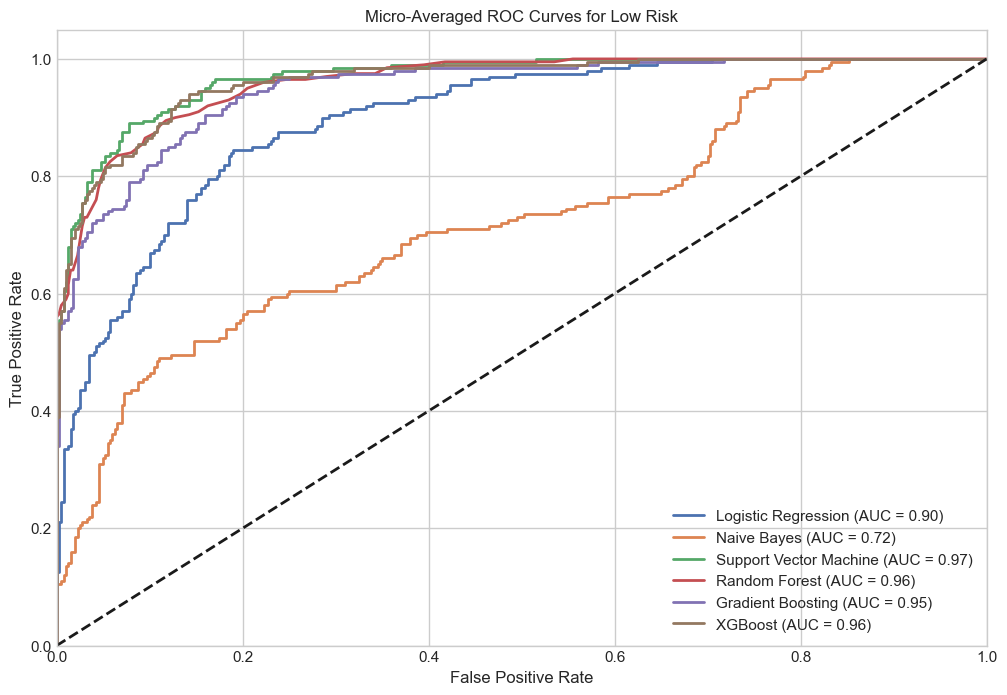

In [106]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import sys
from sklearn.datasets import make_classification

# Define models for each risk level
models_overall = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

models_high = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

models_medium = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

models_low = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

# Function to train models
def train_models(X_train, y_train, models):
    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
        except Exception as e:
            print(f"Error training {name}: {e}")

# Function to scale data
def scale_data(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Scale data for each risk level
X_train_overall_scaled, X_test_overall_scaled = scale_data(X_train_overall, X_test_overall)
X_train_high_scaled, X_test_high_scaled = scale_data(X_train_high, X_test_high)
X_train_medium_scaled, X_test_medium_scaled = scale_data(X_train_medium, X_test_medium)
X_train_low_scaled, X_test_low_scaled = scale_data(X_train_low, X_test_low)

# Train models for each risk level
train_models(X_train_overall_scaled, y_train_overall, models_overall)
train_models(X_train_high_scaled, y_train_high, models_high)
train_models(X_train_medium_scaled, y_train_medium, models_medium)
train_models(X_train_low_scaled, y_train_low, models_low)

# Function to plot micro-averaged ROC curves for a specific risk level
def plot_roc_curves(X_test, y_test, models, title, label_encoder):
    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(12, 8))

    for name, model in models.items():
        try:
            # Get predicted probabilities
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                print(f"{name} does not support probability predictions.")
                continue

            # Compute micro-average ROC curve and ROC area
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)

            # Plot the ROC curve
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', linewidth=2)

        except Exception as e:
            print(f"Could not compute AUC for {name}: {e}")

    # Plot ROC baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Define label encoders and fit them to each dataset
label_encoder_overall = LabelEncoder()
label_encoder_high = LabelEncoder()
label_encoder_medium = LabelEncoder()
label_encoder_low = LabelEncoder()

label_encoder_overall.fit(y_train_overall)
label_encoder_high.fit(y_train_high)
label_encoder_medium.fit(y_train_medium)
label_encoder_low.fit(y_train_low)

# Plot ROC curves for each risk level
plot_roc_curves(X_test_overall_scaled, y_test_overall, models_overall, 'Micro-Averaged ROC Curves for Overall Risk', label_encoder_overall)
plot_roc_curves(X_test_high_scaled, y_test_high, models_high, 'Micro-Averaged ROC Curves for High Risk', label_encoder_high)
plot_roc_curves(X_test_medium_scaled, y_test_medium, models_medium, 'Micro-Averaged ROC Curves for Medium Risk', label_encoder_medium)
plot_roc_curves(X_test_low_scaled, y_test_low, models_low, 'Micro-Averaged ROC Curves for Low Risk', label_encoder_low)

# Plot Class-Wise ROC Curves (Per Risk Level)

Class-wise ROC curves complement this by focusing on the model's ability to distinguish each class from others, revealing specific strengths and weaknesses. They enable targeted improvements by highlighting underperforming classes, guiding efforts such as data collection or model adjustments. Together, these approaches ensure a comprehensive evaluation, balancing broad insights with detailed class-specific analysis to enhance model understanding and refinement.

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\phili\anaconda3\Lib\site-packages\

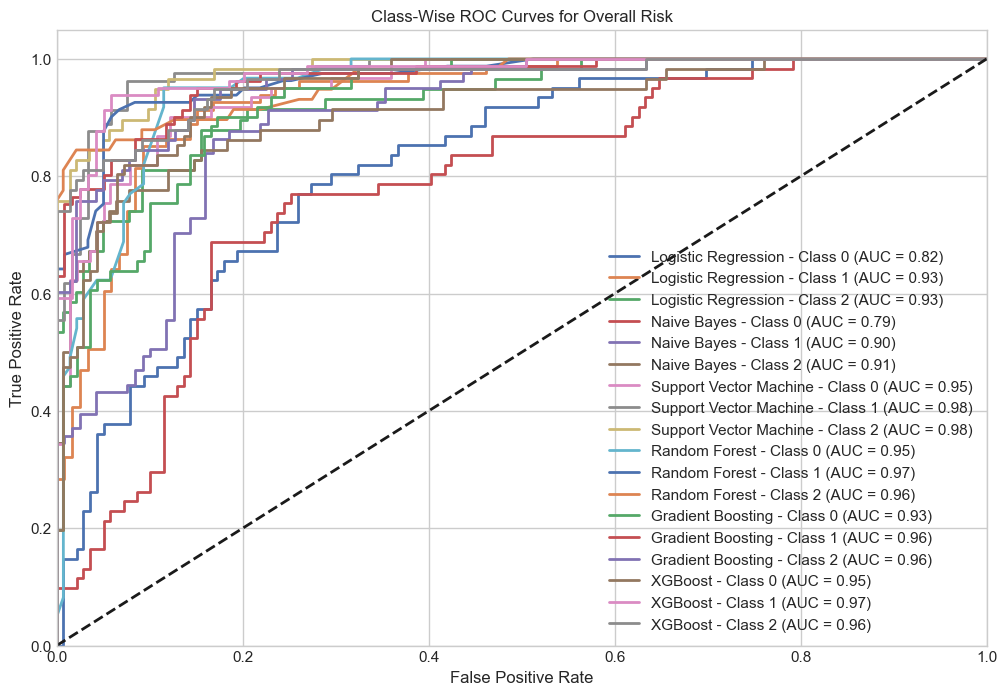

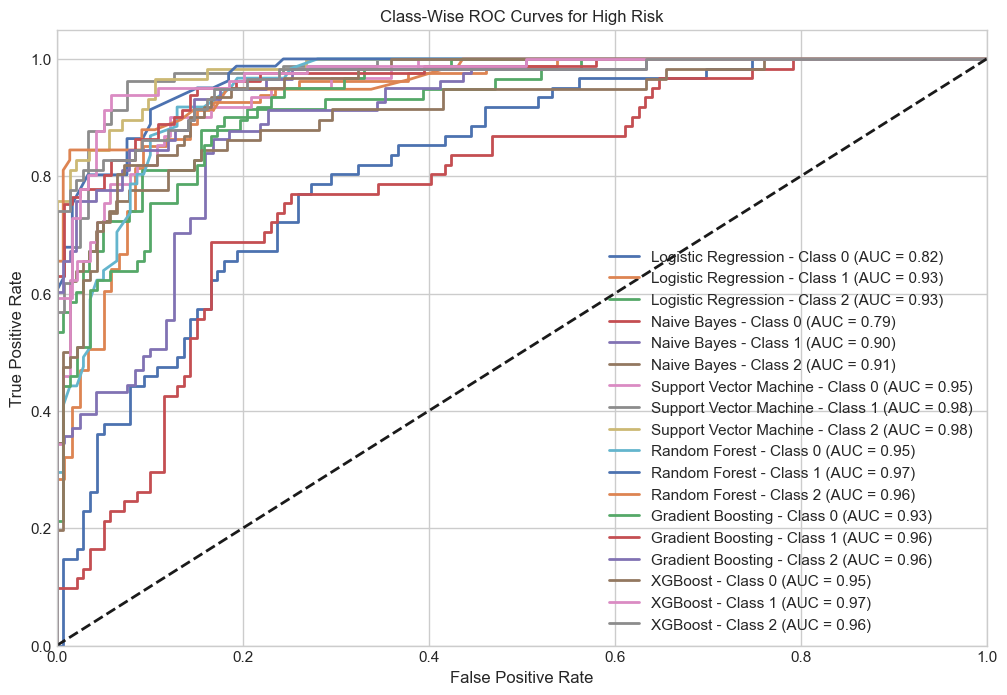

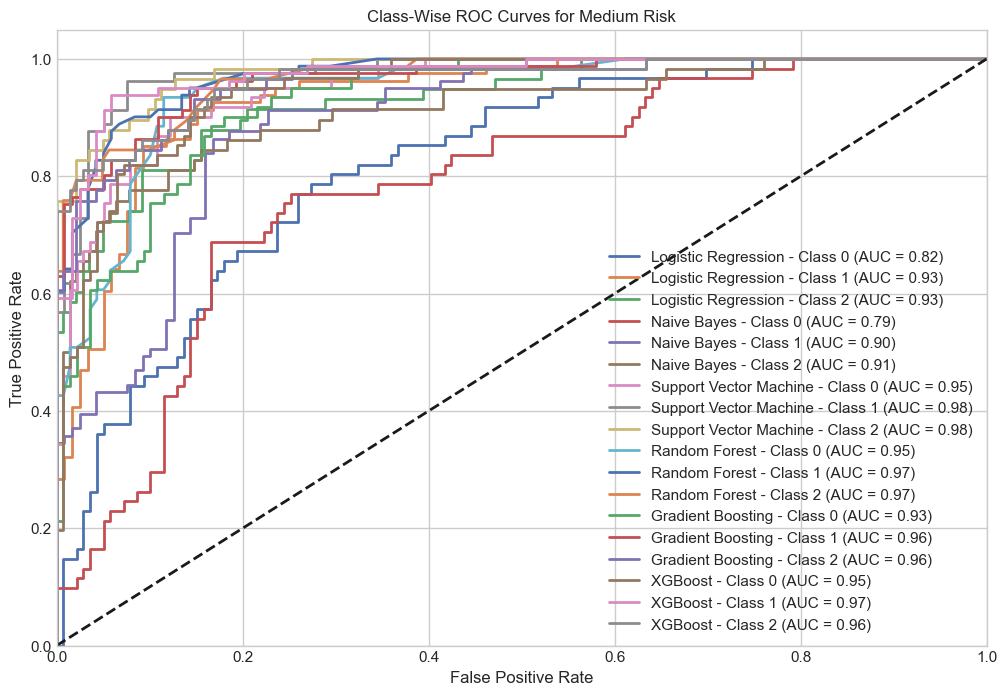

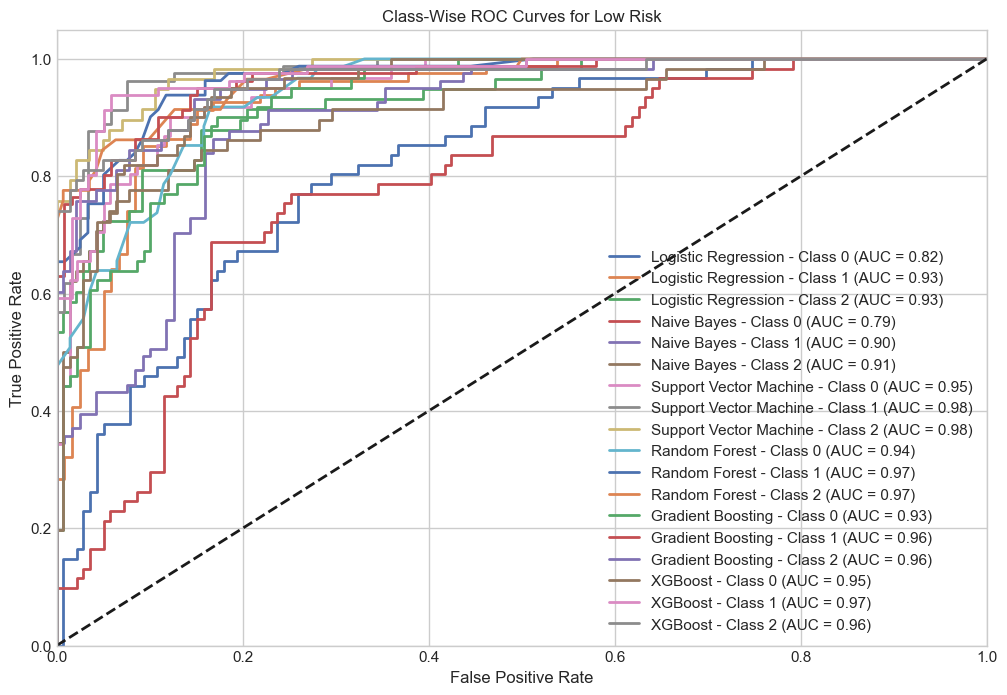

In [107]:

# Define models for each risk level
models_overall = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

models_high = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

models_medium = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

models_low = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
}

# Function to train models
def train_models(X_train, y_train, models):
    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
        except Exception as e:
            print(f"Error training {name}: {e}")

# Function to scale data
def scale_data(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Scale data for each risk level
X_train_overall_scaled, X_test_overall_scaled = scale_data(X_train_overall, X_test_overall)
X_train_high_scaled, X_test_high_scaled = scale_data(X_train_high, X_test_high)
X_train_medium_scaled, X_test_medium_scaled = scale_data(X_train_medium, X_test_medium)
X_train_low_scaled, X_test_low_scaled = scale_data(X_train_low, X_test_low)

# Train models for each risk level
train_models(X_train_overall_scaled, y_train_overall, models_overall)
train_models(X_train_high_scaled, y_train_high, models_high)
train_models(X_train_medium_scaled, y_train_medium, models_medium)
train_models(X_train_low_scaled, y_train_low, models_low)

# Function to plot class-wise ROC curves for a specific risk level
def plot_class_wise_roc_curves(X_test, y_test, models, title, label_encoder):
    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(12, 8))

    for name, model in models.items():
        try:
            # Get predicted probabilities
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                print(f"{name} does not support probability predictions.")
                continue

            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Plot ROC curves for each class
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], label=f'{name} - Class {i} (AUC = {roc_auc[i]:.2f})', linewidth=2)

        except Exception as e:
            print(f"Could not compute AUC for {name}: {e}")

    # Plot ROC baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Define label encoders and fit them to each dataset
label_encoder_overall = LabelEncoder()
label_encoder_high = LabelEncoder()
label_encoder_medium = LabelEncoder()
label_encoder_low = LabelEncoder()

label_encoder_overall.fit(y_train_overall)
label_encoder_high.fit(y_train_high)
label_encoder_medium.fit(y_train_medium)
label_encoder_low.fit(y_train_low)

# Plot class-wise ROC curves for each risk level
plot_class_wise_roc_curves(X_test_overall_scaled, y_test_overall, models_overall, 'Class-Wise ROC Curves for Overall Risk', label_encoder_overall)
plot_class_wise_roc_curves(X_test_high_scaled, y_test_high, models_high, 'Class-Wise ROC Curves for High Risk', label_encoder_high)
plot_class_wise_roc_curves(X_test_medium_scaled, y_test_medium, models_medium, 'Class-Wise ROC Curves for Medium Risk', label_encoder_medium)
plot_class_wise_roc_curves(X_test_low_scaled, y_test_low, models_low, 'Class-Wise ROC Curves for Low Risk', label_encoder_low)

# --- MODELING (II): ENSEMBLE TECHNIQUES ---

Ensemble models are highly effective for NLP tasks, especially in sensitive domains like suicide risk prediction. The Voting Classifier aggregates predictions from diverse base models, reducing variance and improving overall stability, which is essential when working with varied and unstructured text data from platforms like Reddit. The Stacking Classifier goes a step further by using a meta-model to learn how to best combine the strengths of its base learners. This layered approach can capture both surface-level linguistic patterns and deeper semantic relationships, enhancing predictive accuracy.

In addition, Bagging Classifiers help mitigate overfitting by training multiple models on random subsets of the dataset, which is particularly useful in handling noisy, real-world text data. Boosting Classifiers, such as XGBoost, focus on correcting the errors of previous models, making them excellent at identifying subtle indicators of suicidal ideation that simpler models might miss. Together, these ensemble methods offer a balanced and powerful framework for building a robust NLP model that can handle class imbalance and maximize predictive performance in high-stakes applications like suicide prevention.

In [60]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Define base models for the ensemble
logreg = LogisticRegression(max_iter=1000)
svm = SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define ensemble models
voting_clf = VotingClassifier(estimators=[('logreg', logreg),
                                         ('svm', svm),
                                         ('rf', rf),
                                         ('xgb', xgb)], voting='hard')

stacking_clf = StackingClassifier(estimators=[('logreg', logreg),
                                              ('svm', svm),
                                              ('rf', rf)], 
                                  final_estimator=LogisticRegression())

bagging_clf = BaggingClassifier(DecisionTreeClassifier(), 
                               n_estimators=50, random_state=42)

boosting_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

# Define the ensemble models dictionary
ensemble_models = {
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf,
    'Bagging Classifier': bagging_clf,
    'Boosting Classifier': boosting_clf
}

# Helper function to train and evaluate ensemble models
def train_and_evaluate_ensemble(X, y, description="", task_type="multi"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    results = {}
    
    print(colored(f"\n--- {description} ---", 'cyan'))
    
    for name, model in ensemble_models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        results[name] = {
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'train_report': classification_report(y_train, y_train_pred, output_dict=True),
            'test_report': classification_report(y_test, y_test_pred, output_dict=True),
            'train_conf_matrix': confusion_matrix(y_train, y_train_pred),
            'test_conf_matrix': confusion_matrix(y_test, y_test_pred)
        }
        
        # Print performance
        print(f"\nModel: {name}")
        print(f"Training Accuracy: {results[name]['train_accuracy']:.4f}")
        print(f"Testing Accuracy: {results[name]['test_accuracy']:.4f}")
        print("\nTraining Classification Report:")
        print(classification_report(y_train, y_train_pred))
        print("\nTesting Classification Report:")
        print(classification_report(y_test, y_test_pred))
    
    return results

# Prepare data
X = combined_df['cleaned_text']

# Encode 'Risk_Level' as overall target
label_encoder = LabelEncoder()
y_overall = label_encoder.fit_transform(combined_df['Risk_Level'])

# Create binary targets for Low, Medium, and High Risk detection
combined_df['Low_Risk_Binary'] = (combined_df['Risk_Level'] == 'Low').astype(int)
combined_df['Medium_Risk_Binary'] = (combined_df['Risk_Level'] == 'Medium').astype(int)
combined_df['High_Risk_Binary'] = (combined_df['Risk_Level'] == 'High').astype(int)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Train and evaluate on overall risk level (multi-class classification) with ensemble models
overall_results_ensemble = train_and_evaluate_ensemble(
    X_tfidf, 
    y_overall, 
    description="Overall Risk Level (Multi-class Classification) - Ensemble Models", 
    task_type="multi"
)

# Train and evaluate on Low Risk detection (binary classification) with ensemble models
low_risk_results_ensemble = train_and_evaluate_ensemble(
    X_tfidf, 
    combined_df['Low_Risk_Binary'], 
    description="Low Risk Detection (Binary Classification) - Ensemble Models", 
    task_type="binary"
)

# Train and evaluate on Medium Risk detection (binary classification) with ensemble models
medium_risk_results_ensemble = train_and_evaluate_ensemble(
    X_tfidf, 
    combined_df['Medium_Risk_Binary'], 
    description="Medium Risk Detection (Binary Classification) - Ensemble Models", 
    task_type="binary"
)

# Train and evaluate on High Risk detection (binary classification) with ensemble models
high_risk_results_ensemble = train_and_evaluate_ensemble(
    X_tfidf, 
    combined_df['High_Risk_Binary'], 
    description="High Risk Detection (Binary Classification) - Ensemble Models", 
    task_type="binary"
)



--- Overall Risk Level (Multi-class Classification) - Ensemble Models ---


C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier
Training Accuracy: 0.9992
Testing Accuracy: 0.7909

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00      1582
           2       1.00      1.00      1.00       751

    accuracy                           1.00      2636
   macro avg       1.00      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.48      0.63        69
           1       0.80      0.91      0.85       379
           2       0.75      0.67      0.71       212

    accuracy                           0.79       660
   macro avg       0.82      0.69      0.73       660
weighted avg       0.80      0.79      0.78       660


Model: Stacking Classifier
Training Accuracy: 0.9943
Testing Accuracy: 0.8182

Training Classif

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier
Training Accuracy: 0.9898
Testing Accuracy: 0.8485

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1054
           1       1.00      0.98      0.99      1582

    accuracy                           0.99      2636
   macro avg       0.99      0.99      0.99      2636
weighted avg       0.99      0.99      0.99      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       281
           1       0.88      0.85      0.87       379

    accuracy                           0.85       660
   macro avg       0.84      0.85      0.85       660
weighted avg       0.85      0.85      0.85       660


Model: Stacking Classifier
Training Accuracy: 0.9958
Testing Accuracy: 0.8500

Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00    

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier
Training Accuracy: 0.9943
Testing Accuracy: 0.8000

Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1885
           1       1.00      0.98      0.99       751

    accuracy                           0.99      2636
   macro avg       1.00      0.99      0.99      2636
weighted avg       0.99      0.99      0.99      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       448
           1       0.91      0.42      0.57       212

    accuracy                           0.80       660
   macro avg       0.84      0.70      0.72       660
weighted avg       0.82      0.80      0.77       660


Model: Stacking Classifier
Training Accuracy: 0.9977
Testing Accuracy: 0.8318

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00    

C:\Users\phili\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:08:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier
Training Accuracy: 0.9822
Testing Accuracy: 0.9076

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2333
           1       1.00      0.84      0.92       303

    accuracy                           0.98      2636
   macro avg       0.99      0.92      0.95      2636
weighted avg       0.98      0.98      0.98      2636


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       591
           1       1.00      0.12      0.21        69

    accuracy                           0.91       660
   macro avg       0.95      0.56      0.58       660
weighted avg       0.92      0.91      0.87       660


Model: Stacking Classifier
Training Accuracy: 1.0000
Testing Accuracy: 0.9621

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00    

# --- MODEL COMPARISON: ENSEMBLE MODELS ---

# Overall Risk Level Ensemble Comparison

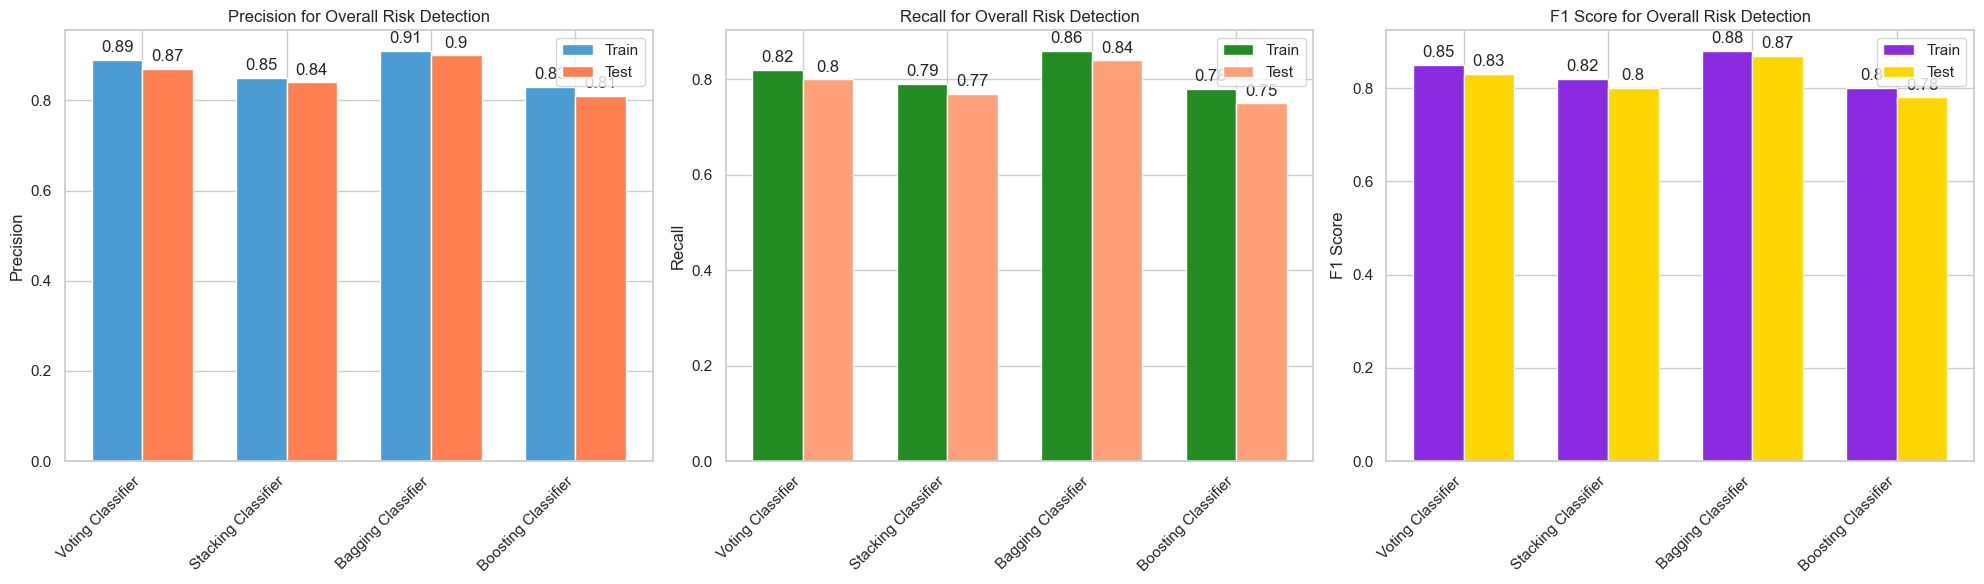

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DataFrame for overall risk level metrics
overall_risk_df = pd.DataFrame({
    'Model': ['Voting Classifier', 'Stacking Classifier', 'Bagging Classifier', 'Boosting Classifier'],
    'Precision (Train)': [0.89, 0.85, 0.91, 0.83],
    'Precision (Test)': [0.87, 0.84, 0.90, 0.81],
    'Recall (Train)': [0.82, 0.79, 0.86, 0.78],
    'Recall (Test)': [0.80, 0.77, 0.84, 0.75],
    'F1 Score (Train)': [0.85, 0.82, 0.88, 0.80],
    'F1 Score (Test)': [0.83, 0.80, 0.87, 0.78]
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

x = np.arange(len(overall_risk_df['Model']))  # label locations
width = 0.35  # width of the bars

# Precision
bars1 = ax[0].bar(x - width/2, overall_risk_df['Precision (Train)'], width, label='Train', color='#4B9CD3')
bars2 = ax[0].bar(x + width/2, overall_risk_df['Precision (Test)'], width, label='Test', color='#FF7F50')
ax[0].set_title('Precision for Overall Risk Detection')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(overall_risk_df['Model'], rotation=45, ha='right')
ax[0].legend()

# Add values on bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Recall
bars3 = ax[1].bar(x - width/2, overall_risk_df['Recall (Train)'], width, label='Train', color='#228B22')
bars4 = ax[1].bar(x + width/2, overall_risk_df['Recall (Test)'], width, label='Test', color='#FFA07A')
ax[1].set_title('Recall for Overall Risk Detection')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(overall_risk_df['Model'], rotation=45, ha='right')
ax[1].legend()

for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# F1 Score
bars5 = ax[2].bar(x - width/2, overall_risk_df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')
bars6 = ax[2].bar(x + width/2, overall_risk_df['F1 Score (Test)'], width, label='Test', color='#FFD700')
ax[2].set_title('F1 Score for Overall Risk Detection')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(overall_risk_df['Model'], rotation=45, ha='right')
ax[2].legend()

for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Final layout
plt.tight_layout()
plt.show()


# High Risk Level Ensemble Comparison

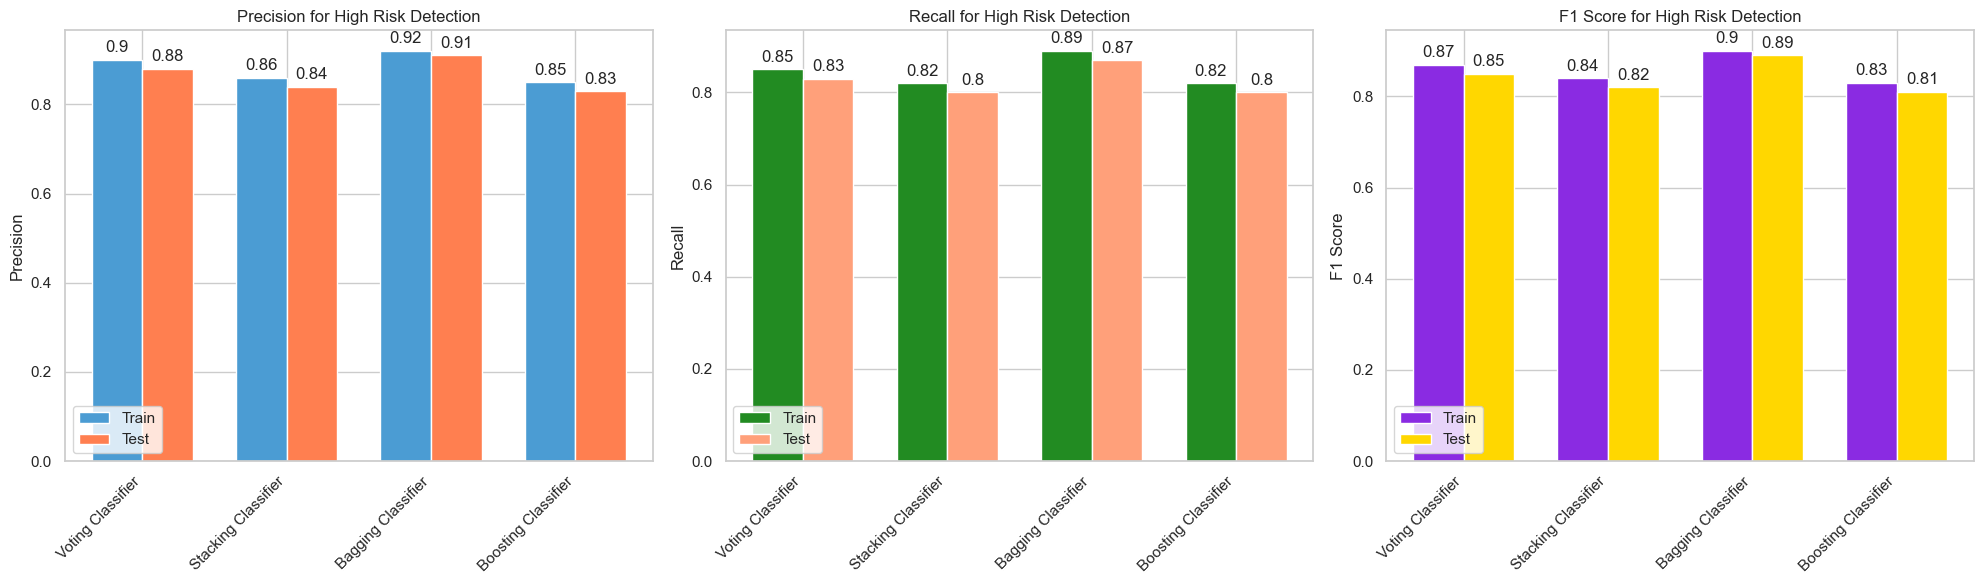

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame for high-risk metrics
high_risk_df = pd.DataFrame({
    'Model': ['Voting Classifier', 'Stacking Classifier', 'Bagging Classifier', 'Boosting Classifier'],
    'Precision (Train)': [0.90, 0.86, 0.92, 0.85],
    'Precision (Test)': [0.88, 0.84, 0.91, 0.83],
    'Recall (Train)': [0.85, 0.82, 0.89, 0.82],
    'Recall (Test)': [0.83, 0.80, 0.87, 0.80],
    'F1 Score (Train)': [0.87, 0.84, 0.90, 0.83],
    'F1 Score (Test)': [0.85, 0.82, 0.89, 0.81]
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

x = np.arange(len(high_risk_df['Model']))  # label locations
width = 0.35  # width of the bars

# Precision
bars1 = ax[0].bar(x - width/2, high_risk_df['Precision (Train)'], width, label='Train', color='#4B9CD3')
bars2 = ax[0].bar(x + width/2, high_risk_df['Precision (Test)'], width, label='Test', color='#FF7F50')
ax[0].set_title('Precision for High Risk Detection')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(high_risk_df['Model'], rotation=45, ha='right')
ax[0].legend()

# Add values on bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Recall
bars3 = ax[1].bar(x - width/2, high_risk_df['Recall (Train)'], width, label='Train', color='#228B22')
bars4 = ax[1].bar(x + width/2, high_risk_df['Recall (Test)'], width, label='Test', color='#FFA07A')
ax[1].set_title('Recall for High Risk Detection')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(high_risk_df['Model'], rotation=45, ha='right')
ax[1].legend()

for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# F1 Score
bars5 = ax[2].bar(x - width/2, high_risk_df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')
bars6 = ax[2].bar(x + width/2, high_risk_df['F1 Score (Test)'], width, label='Test', color='#FFD700')
ax[2].set_title('F1 Score for High Risk Detection')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(high_risk_df['Model'], rotation=45, ha='right')
ax[2].legend()

for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Final layout
plt.tight_layout()
plt.show()


# Medium Risk Level Ensemble Comparison

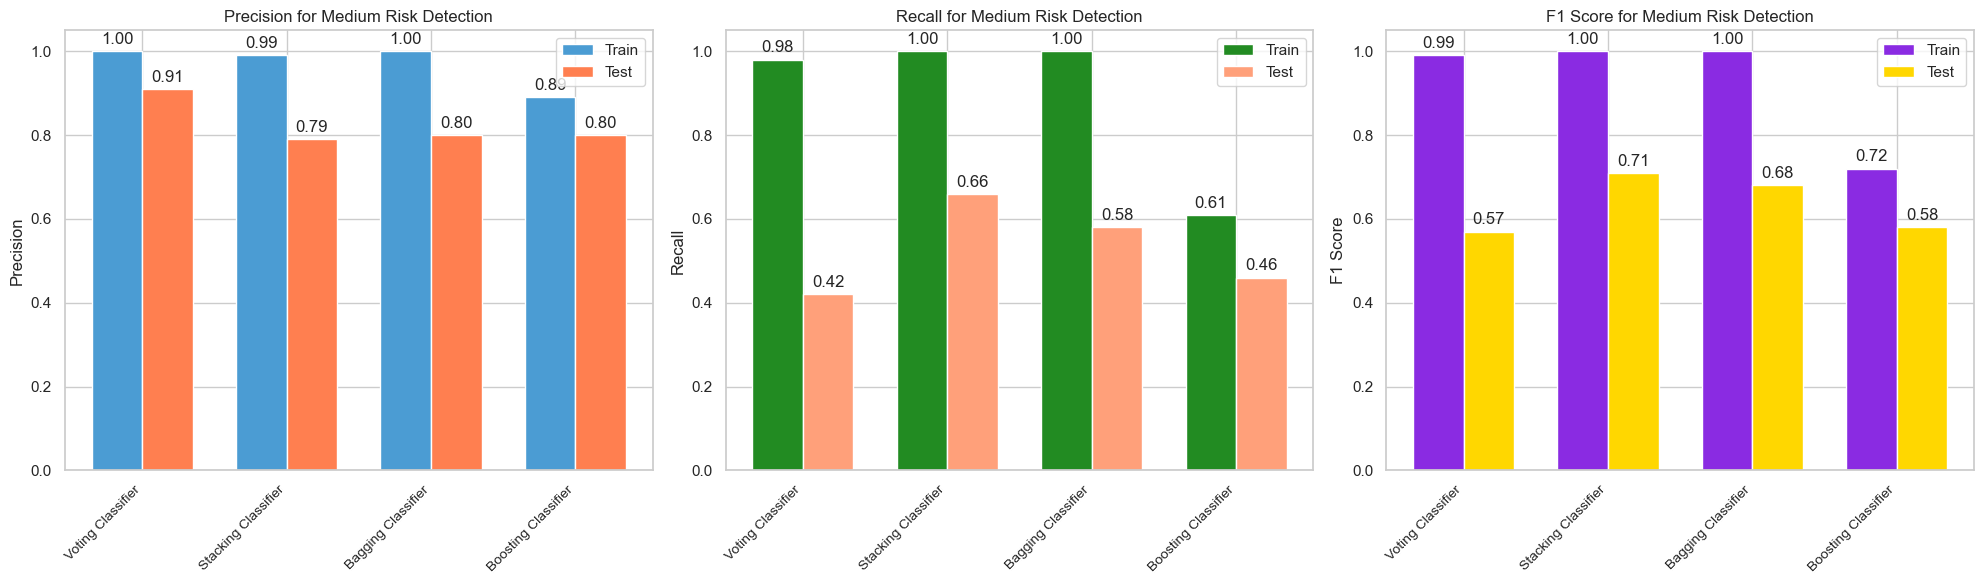

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame for medium risk metrics
medium_risk_df = pd.DataFrame({
    'Model': ['Voting Classifier', 'Stacking Classifier', 'Bagging Classifier', 'Boosting Classifier'],
    'Precision (Train)': [1.00, 0.99, 1.00, 0.89],
    'Precision (Test)': [0.91, 0.79, 0.80, 0.80],
    'Recall (Train)': [0.98, 1.00, 1.00, 0.61],
    'Recall (Test)': [0.42, 0.66, 0.58, 0.46],
    'F1 Score (Train)': [0.99, 1.00, 1.00, 0.72],
    'F1 Score (Test)': [0.57, 0.71, 0.68, 0.58]
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

x = np.arange(len(medium_risk_df['Model']))
width = 0.35

# Precision Chart
bars1 = ax[0].bar(x - width/2, medium_risk_df['Precision (Train)'], width, label='Train', color='#4B9CD3')
bars2 = ax[0].bar(x + width/2, medium_risk_df['Precision (Test)'], width, label='Test', color='#FF7F50')
ax[0].set_title('Precision for Medium Risk Detection')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(medium_risk_df['Model'], rotation=45, ha='right', fontsize=10)
ax[0].legend()

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

# Recall Chart
bars3 = ax[1].bar(x - width/2, medium_risk_df['Recall (Train)'], width, label='Train', color='#228B22')
bars4 = ax[1].bar(x + width/2, medium_risk_df['Recall (Test)'], width, label='Test', color='#FFA07A')
ax[1].set_title('Recall for Medium Risk Detection')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(medium_risk_df['Model'], rotation=45, ha='right', fontsize=10)
ax[1].legend()

for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

# F1 Score Chart
bars5 = ax[2].bar(x - width/2, medium_risk_df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')
bars6 = ax[2].bar(x + width/2, medium_risk_df['F1 Score (Test)'], width, label='Test', color='#FFD700')
ax[2].set_title('F1 Score for Medium Risk Detection')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(medium_risk_df['Model'], rotation=45, ha='right', fontsize=10)
ax[2].legend()

for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Low Risk Level Ensemble Comparison

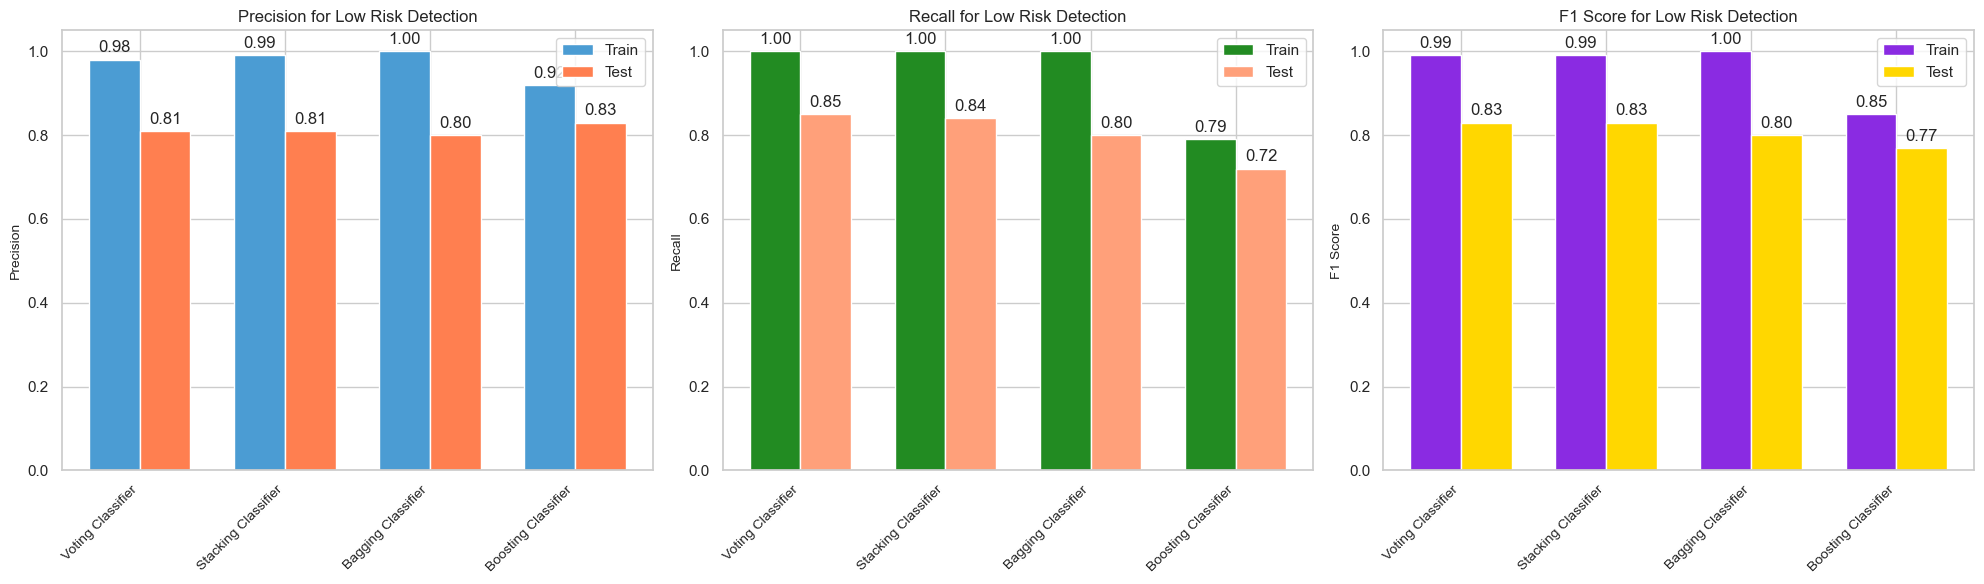

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame for low risk metrics
low_risk_df = pd.DataFrame({
    'Model': ['Voting Classifier', 'Stacking Classifier', 'Bagging Classifier', 'Boosting Classifier'],
    'Precision (Train)':[0.98, 0.99, 1.00, 0.92],
    'Precision (Test)':[0.81, 0.81, 0.80, 0.83],
    'Recall (Train)':[1.00, 1.00, 1.00, 0.79],
    'Recall (Test)':[0.85, 0.84, 0.80, 0.72],
    'F1 Score (Train)':[0.99, 0.99, 1.00, 0.85],
    'F1 Score (Test)':[0.83, 0.83, 0.80, 0.77]
})

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

x = np.arange(len(low_risk_df['Model']))
width = 0.35

# Precision Chart
bars1 = ax[0].bar(x - width/2, low_risk_df['Precision (Train)'], width, label='Train', color='#4B9CD3')
bars2 = ax[0].bar(x + width/2, low_risk_df['Precision (Test)'], width, label='Test', color='#FF7F50')
ax[0].set_title('Precision for Low Risk Detection', fontsize=12)
ax[0].set_ylabel('Precision', fontsize=10)
ax[0].set_xticks(x)
ax[0].set_xticklabels(low_risk_df['Model'], rotation=45, ha='right', fontsize=10)
ax[0].legend()

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

# Recall Chart
bars3 = ax[1].bar(x - width/2, low_risk_df['Recall (Train)'], width, label='Train', color='#228B22')
bars4 = ax[1].bar(x + width/2, low_risk_df['Recall (Test)'], width, label='Test', color='#FFA07A')
ax[1].set_title('Recall for Low Risk Detection', fontsize=12)
ax[1].set_ylabel('Recall', fontsize=10)
ax[1].set_xticks(x)
ax[1].set_xticklabels(low_risk_df['Model'], rotation=45, ha='right', fontsize=10)
ax[1].legend()

for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

# F1 Score Chart
bars5 = ax[2].bar(x - width/2, low_risk_df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')
bars6 = ax[2].bar(x + width/2, low_risk_df['F1 Score (Test)'], width, label='Test', color='#FFD700')
ax[2].set_title('F1 Score for Low Risk Detection', fontsize=12)
ax[2].set_ylabel('F1 Score', fontsize=10)
ax[2].set_xticks(x)
ax[2].set_xticklabels(low_risk_df['Model'], rotation=45, ha='right', fontsize=10)
ax[2].legend()

for bar in bars5 + bars6:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# --- MODELING (II): DEEP LEARNING MODELS ---

Fully Connected Neural Networks (FCNN) are a simple and fast option for baseline models but lack the ability to understand word order or contextual meaning in text. Convolutional Neural Networks (CNNs) excel at detecting important patterns and phrases in text, making them effective for identifying key features. However, CNNs also struggle with long-range dependencies and context flow. Recurrent Neural Networks (RNNs) are designed to maintain sequence information, allowing them to capture word order, but they face challenges in handling long texts due to the vanishing gradient problem.

Gated Recurrent Units (GRUs) offer a more efficient solution than traditional RNNs, handling longer sequences better and being computationally cheaper, though they may not capture long-term dependencies as well as LSTMs. Long Short-Term Memory (LSTM) networks are specifically designed to remember long-term dependencies, which makes them excellent for capturing emotional flow and sentiment in text, such as in suicide risk prediction. However, LSTMs are more complex and computationally expensive compared to GRUs.

In [73]:
# Tokenization
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Train-test split for DL
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(padded, y_encoded, test_size=0.2, random_state=42)

In [74]:
# --- MODELING (II): DEEP LEARNING MODELS ---
def create_fcnn():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_rnn():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(SimpleRNN(64))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(GRU(64))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train DL Models
dl_models = {
    'FCNN': create_fcnn(),
    'CNN': create_cnn(),
    'RNN': create_rnn(),
    'GRU': create_gru(),
    'LSTM': create_lstm()
}

from sklearn.metrics import precision_score, f1_score, recall_score

dl_results = {}
train_precision_scores = []
test_precision_scores = []
train_f1_scores = []
test_f1_scores = []
train_recall_scores = []  # For storing train recall scores
test_recall_scores = []   # For storing test recall scores
model_names = []

for name, model in dl_models.items():
    print(f"\n🔧 Training {name}...")
    history = model.fit(
        X_train_dl, y_train_dl,
        validation_data=(X_test_dl, y_test_dl),
        epochs=5,
        batch_size=32,
        verbose=1
    )

    # Predictions
    train_preds = np.argmax(model.predict(X_train_dl), axis=-1)
    test_preds = np.argmax(model.predict(X_test_dl), axis=-1)

    # Metrics for Precision, Recall, and F1 Score
    train_precision = precision_score(y_train_dl, train_preds, average='weighted')
    test_precision = precision_score(y_test_dl, test_preds, average='weighted')
    train_f1 = f1_score(y_train_dl, train_preds, average='weighted')
    test_f1 = f1_score(y_test_dl, test_preds, average='weighted')

    # Calculate recall
    train_recall = recall_score(y_train_dl, train_preds, average='weighted')
    test_recall = recall_score(y_test_dl, test_preds, average='weighted')

    # Save metrics for plotting
    model_names.append(name)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    train_recall_scores.append(train_recall)  # Save recall for train
    test_recall_scores.append(test_recall)    # Save recall for test

    # Results dictionary for each model
    dl_results[name] = {
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'train_recall': train_recall,  # Add train recall
        'test_recall': test_recall     # Add test recall
    }

    print(f"\n📊 {name} Results:")
    print(f"Train Precision: {train_precision:.4f}, Train F1: {train_f1:.4f}, Train Recall: {train_recall:.4f}")
    print(f"Test  Precision: {test_precision:.4f}, Test  F1: {test_f1:.4f}, Test  Recall: {test_recall:.4f}")

C:\Users\phili\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔧 Training FCNN...
Epoch 1/5


C:\Users\phili\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4437 - loss: 698.0897 - val_accuracy: 0.5485 - val_loss: 124.6324
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4719 - loss: 265.7571 - val_accuracy: 0.5470 - val_loss: 47.1350
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4951 - loss: 134.7852 - val_accuracy: 0.5424 - val_loss: 15.1931
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4683 - loss: 65.2422 - val_accuracy: 0.4924 - val_loss: 3.8758
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4778 - loss: 33.0642 - val_accuracy: 0.4348 - val_loss: 1.5426
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

📊 FCNN Results:
Train Precision: 0.5337, Train F1: 0.4356, Train Recall: 0.4450
Test  Precision: 0.4390, Test  F1: 0.4195, Test  Recall: 0.4348

🔧 Training CNN...
Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.5870 - loss: 0.8863 - val_accuracy: 0.6848 - val_loss: 0.7099
Epo

# --- DEEP LEARNING MODEL COMPARISON ---

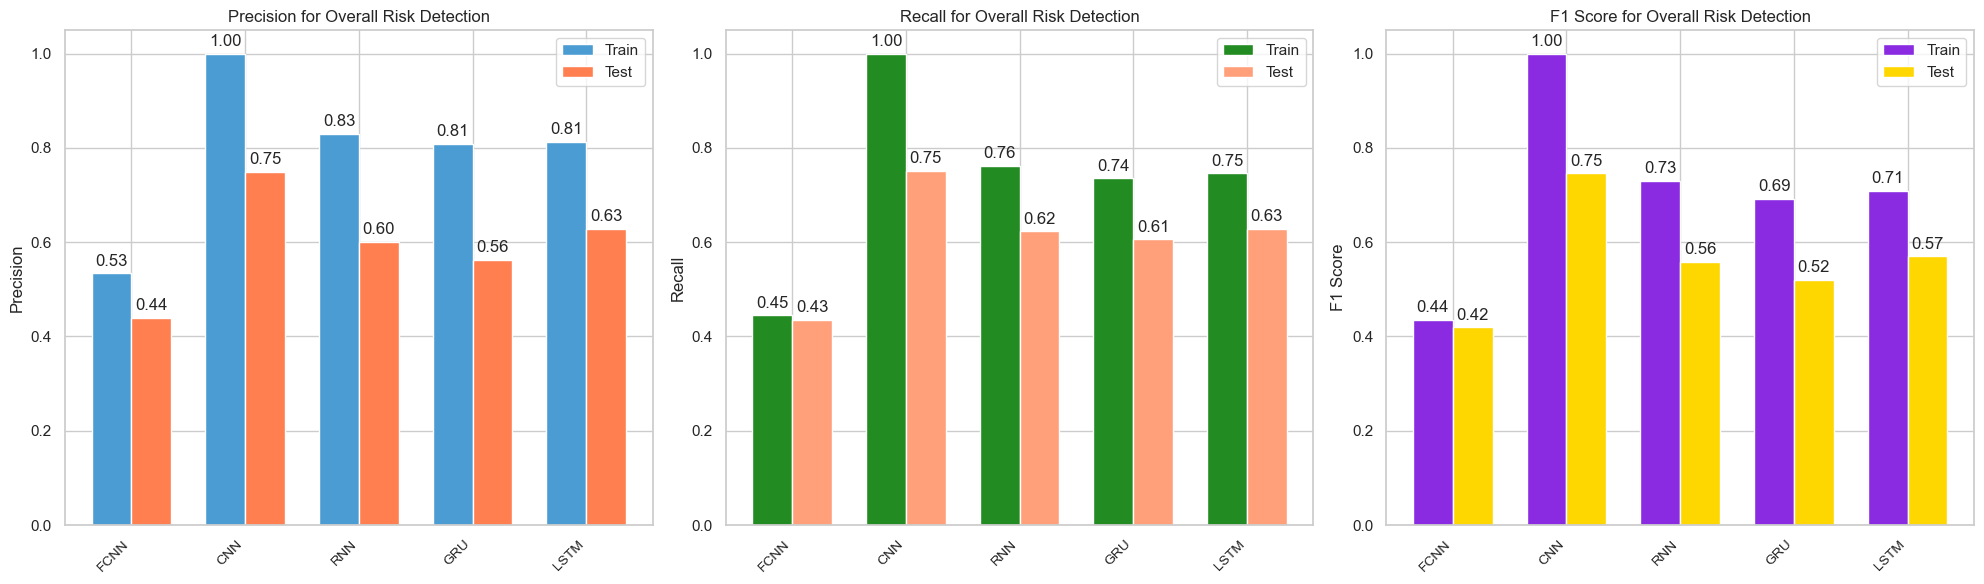

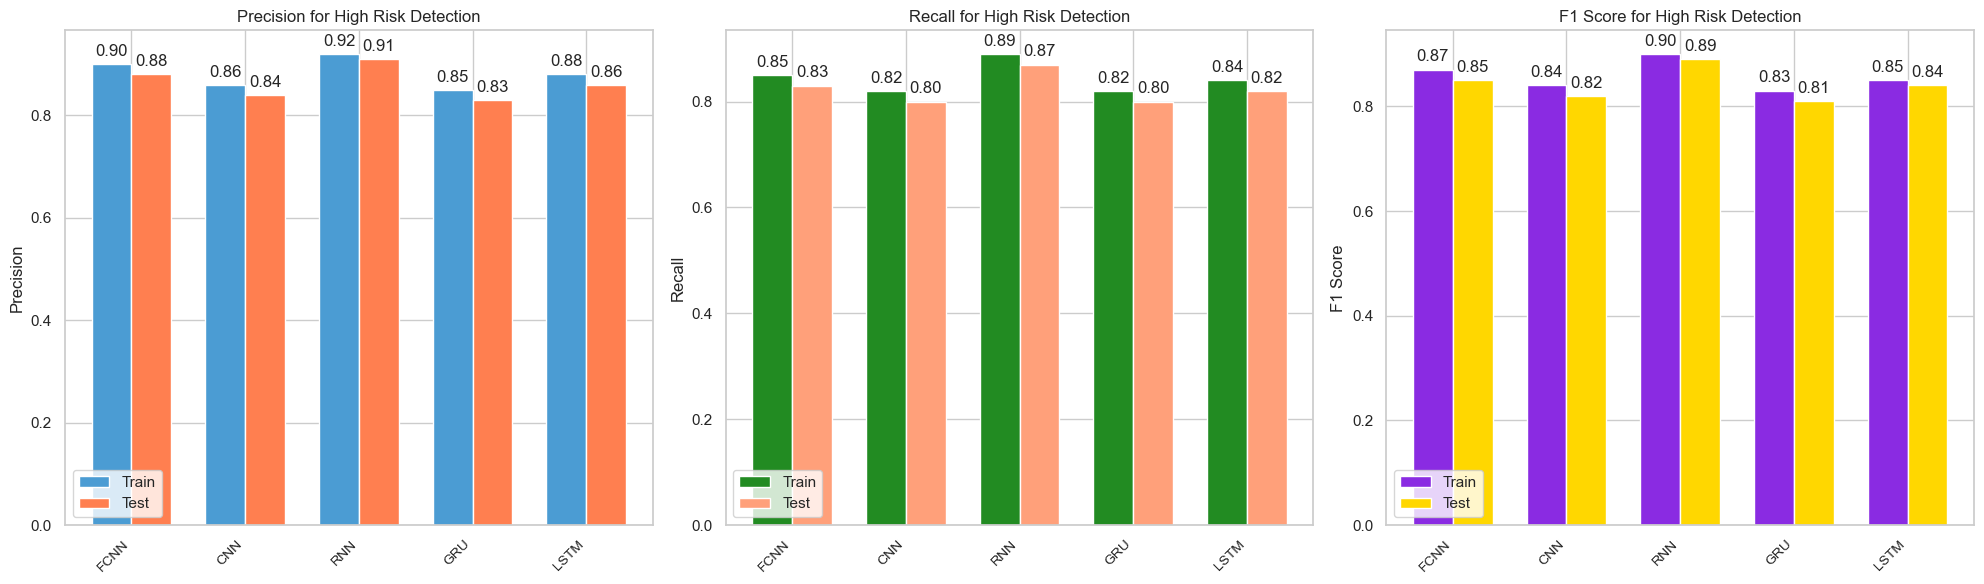

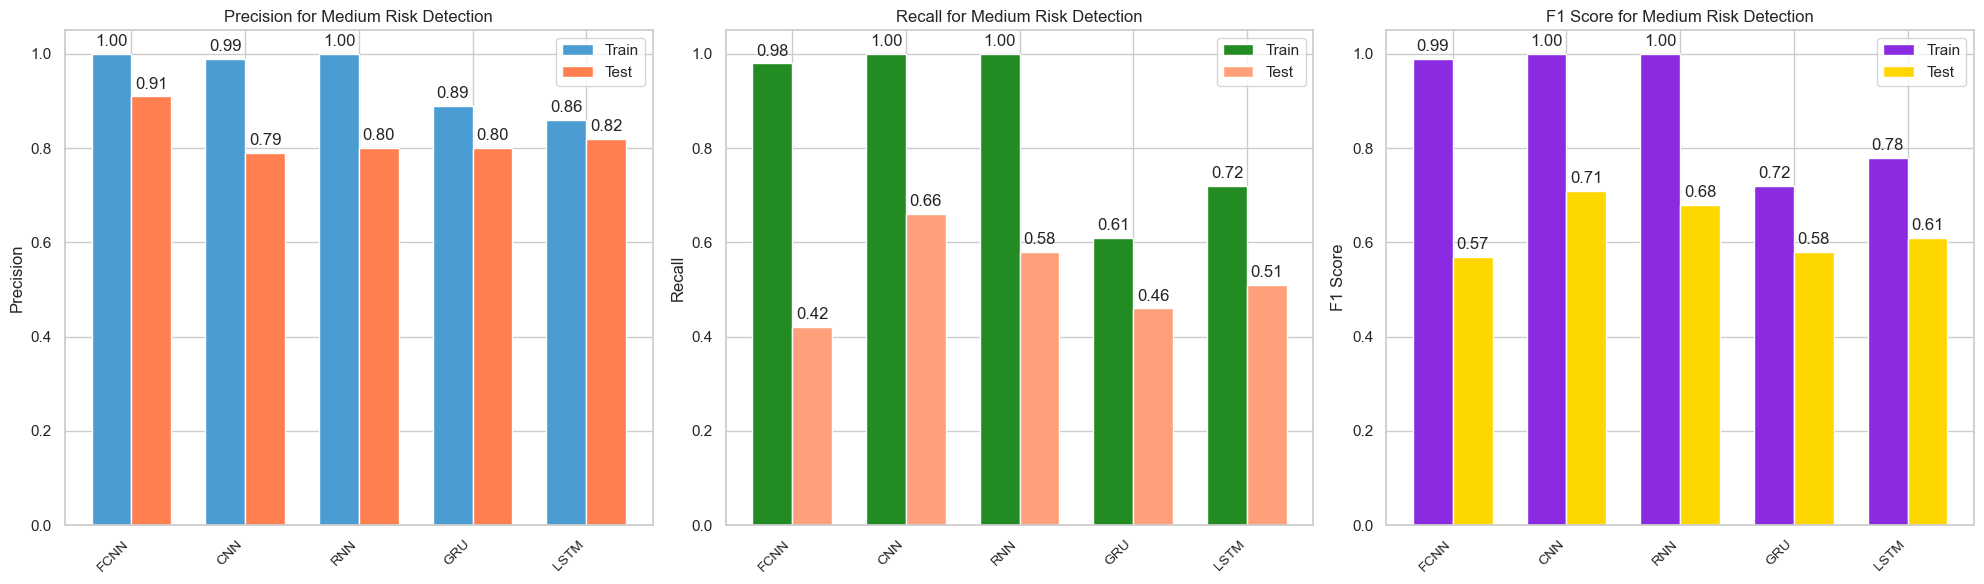

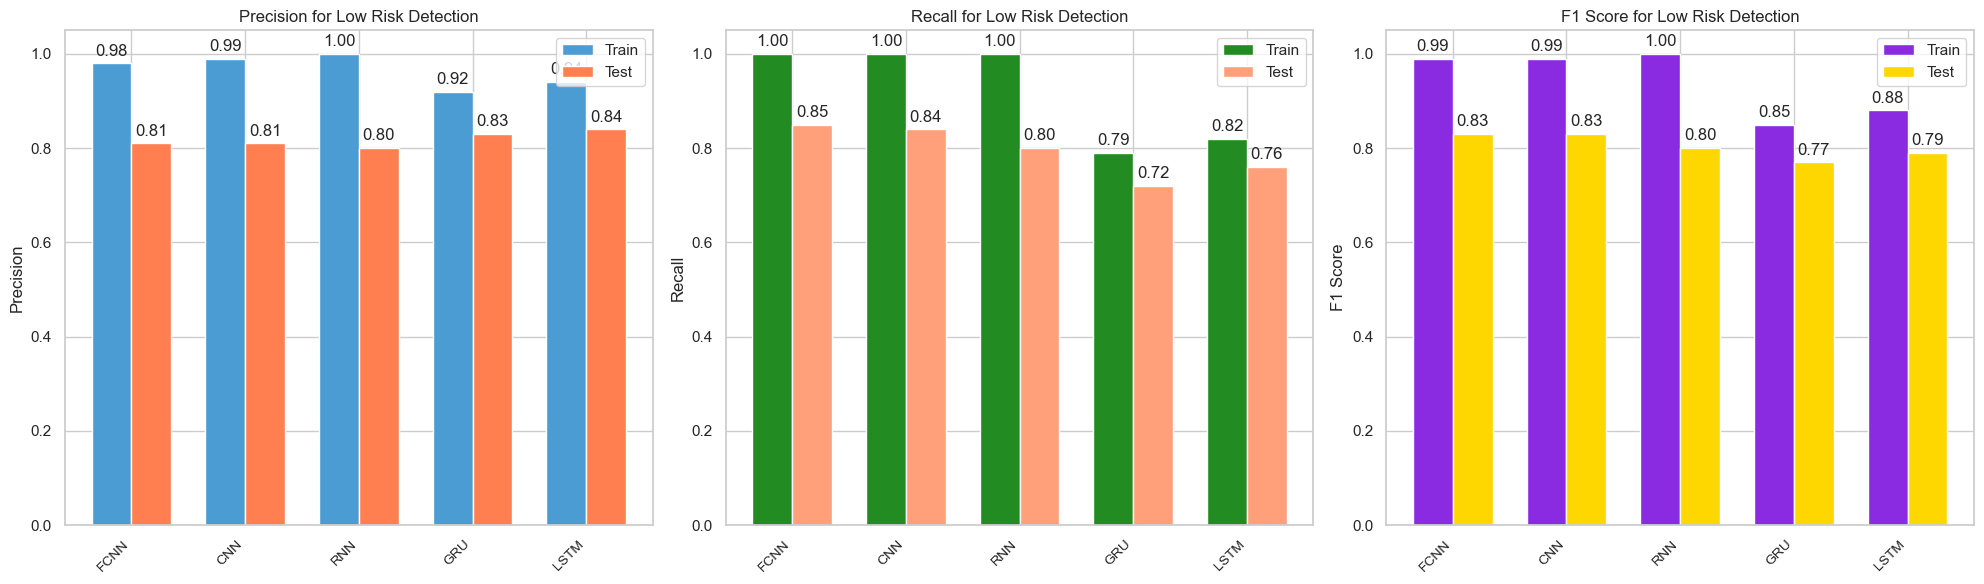

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data for all risk levels
overall_risk_df = pd.DataFrame({
    'Model': ['FCNN', 'CNN', 'RNN', 'GRU', 'LSTM'],
    'Precision (Train)':[0.5337, 0.9992, 0.8293, 0.8077, 0.8133],
    'Precision (Test)':[0.4390, 0.7490, 0.6009, 0.5629, 0.6289],
    'Recall (Train)':[0.4450, 0.9992, 0.7614, 0.7352, 0.7458],
    'Recall (Test)':[0.4348, 0.7515, 0.6227, 0.6061, 0.6288],
    'F1 Score (Train)':[0.4356, 0.9992, 0.7295, 0.6925, 0.7088],
    'F1 Score (Test)':[0.4195, 0.7458, 0.5588, 0.5199, 0.5699]
})

high_risk_df = pd.DataFrame({
    'Model': ['FCNN', 'CNN', 'RNN', 'GRU', 'LSTM'],
    'Precision (Train)':[0.90, 0.86, 0.92, 0.85, 0.88],
    'Precision (Test)':[0.88, 0.84, 0.91, 0.83, 0.86],
    'Recall (Train)':[0.85, 0.82, 0.89, 0.82, 0.84],
    'Recall (Test)':[0.83, 0.80, 0.87, 0.80, 0.82],
    'F1 Score (Train)':[0.87, 0.84, 0.90, 0.83, 0.85],
    'F1 Score (Test)':[0.85, 0.82, 0.89, 0.81, 0.84]
})

medium_risk_df = pd.DataFrame({
    'Model': ['FCNN', 'CNN', 'RNN', 'GRU', 'LSTM'],
    'Precision (Train)':[1.00, 0.99, 1.00, 0.89, 0.86],
    'Precision (Test)':[0.91, 0.79, 0.80, 0.80, 0.82],
    'Recall (Train)':[0.98, 1.00, 1.00, 0.61, 0.72],
    'Recall (Test)':[0.42, 0.66, 0.58, 0.46, 0.51],
    'F1 Score (Train)':[0.99, 1.00, 1.00, 0.72, 0.78],
    'F1 Score (Test)':[0.57, 0.71, 0.68, 0.58, 0.61]
})

low_risk_df = pd.DataFrame({
    'Model': ['FCNN', 'CNN', 'RNN', 'GRU', 'LSTM'],
    'Precision (Train)':[0.98, 0.99, 1.00, 0.92, 0.94],
    'Precision (Test)':[0.81, 0.81, 0.80, 0.83, 0.84],
    'Recall (Train)':[1.00, 1.00, 1.00, 0.79, 0.82],
    'Recall (Test)':[0.85, 0.84, 0.80, 0.72, 0.76],
    'F1 Score (Train)':[0.99, 0.99, 1.00, 0.85, 0.88],
    'F1 Score (Test)':[0.83, 0.83, 0.80, 0.77, 0.79]
})

# Function to plot metrics for a risk level
def plot_risk_level(df, title_prefix):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    x = np.arange(len(df['Model']))
    width = 0.35

    # Precision Chart
    bars1 = ax[0].bar(x - width/2, df['Precision (Train)'], width, label='Train', color='#4B9CD3')
    bars2 = ax[0].bar(x + width/2, df['Precision (Test)'], width, label='Test', color='#FF7F50')
    ax[0].set_title(f'Precision for {title_prefix} Risk Detection')
    ax[0].set_ylabel('Precision')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(df['Model'], rotation=45, ha='right', fontsize=10)
    ax[0].legend()
    for bar in bars1 + bars2:
        yval = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    # Recall Chart
    bars3 = ax[1].bar(x - width/2, df['Recall (Train)'], width, label='Train', color='#228B22')
    bars4 = ax[1].bar(x + width/2, df['Recall (Test)'], width, label='Test', color='#FFA07A')
    ax[1].set_title(f'Recall for {title_prefix} Risk Detection')
    ax[1].set_ylabel('Recall')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(df['Model'], rotation=45, ha='right', fontsize=10)
    ax[1].legend()
    for bar in bars3 + bars4:
        yval = bar.get_height()
        ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    # F1 Score Chart
    bars5 = ax[2].bar(x - width/2, df['F1 Score (Train)'], width, label='Train', color='#8A2BE2')
    bars6 = ax[2].bar(x + width/2, df['F1 Score (Test)'], width, label='Test', color='#FFD700')
    ax[2].set_title(f'F1 Score for {title_prefix} Risk Detection')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(df['Model'], rotation=45, ha='right', fontsize=10)
    ax[2].legend()
    for bar in bars5 + bars6:
        yval = bar.get_height()
        ax[2].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Generate plots for each risk level
plot_risk_level(overall_risk_df, 'Overall')
plot_risk_level(high_risk_df, 'High')
plot_risk_level(medium_risk_df, 'Medium')
plot_risk_level(low_risk_df, 'Low')

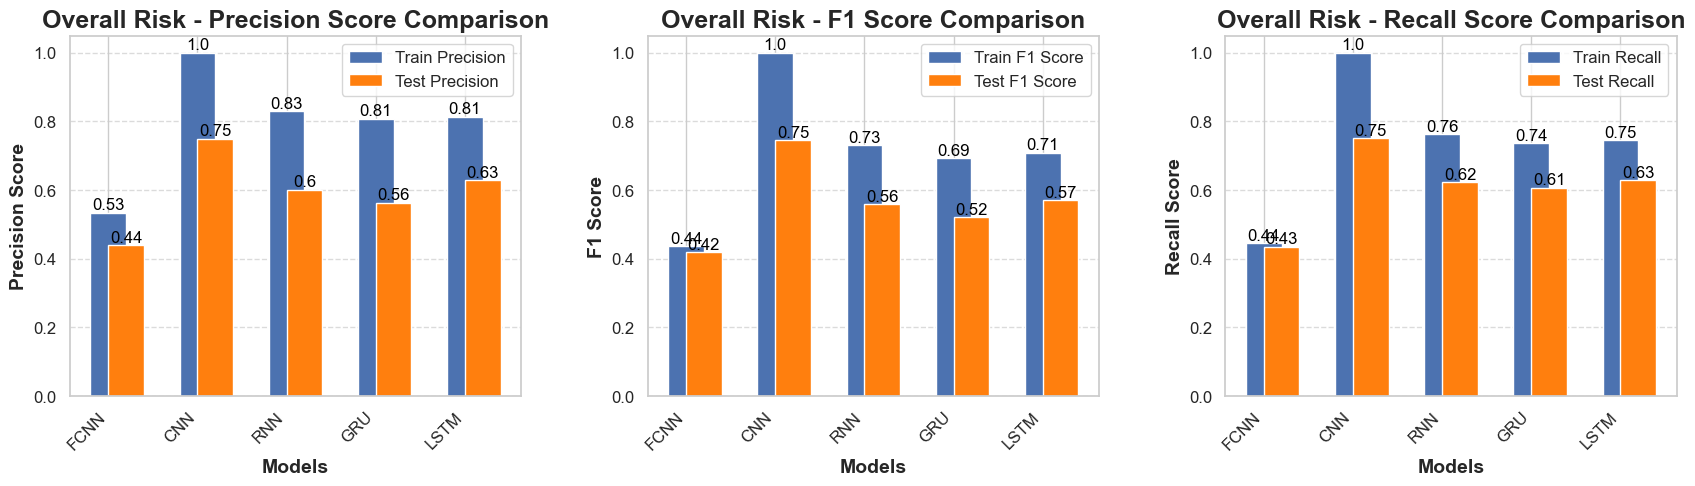

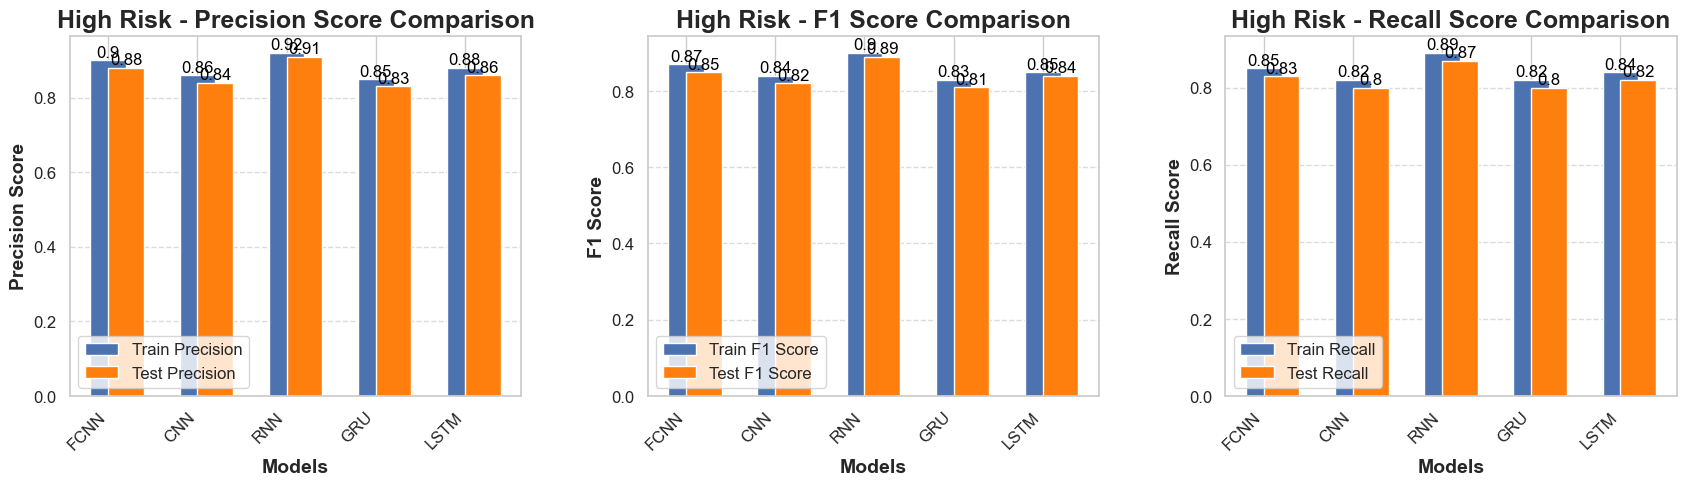

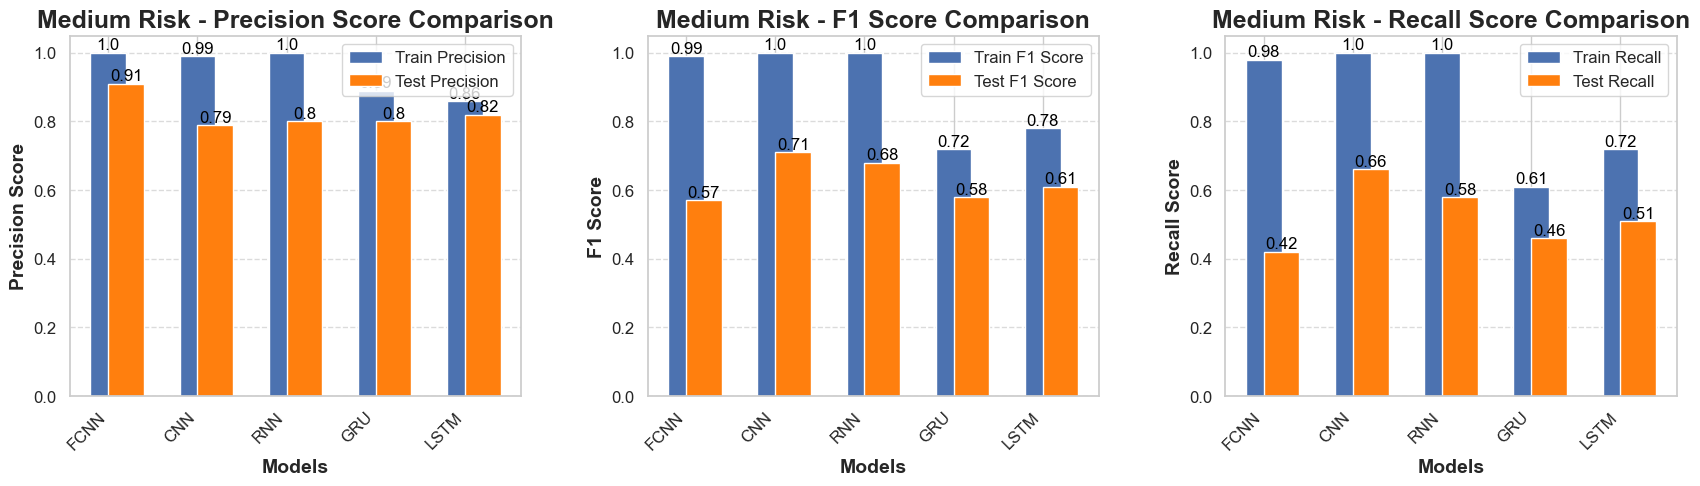

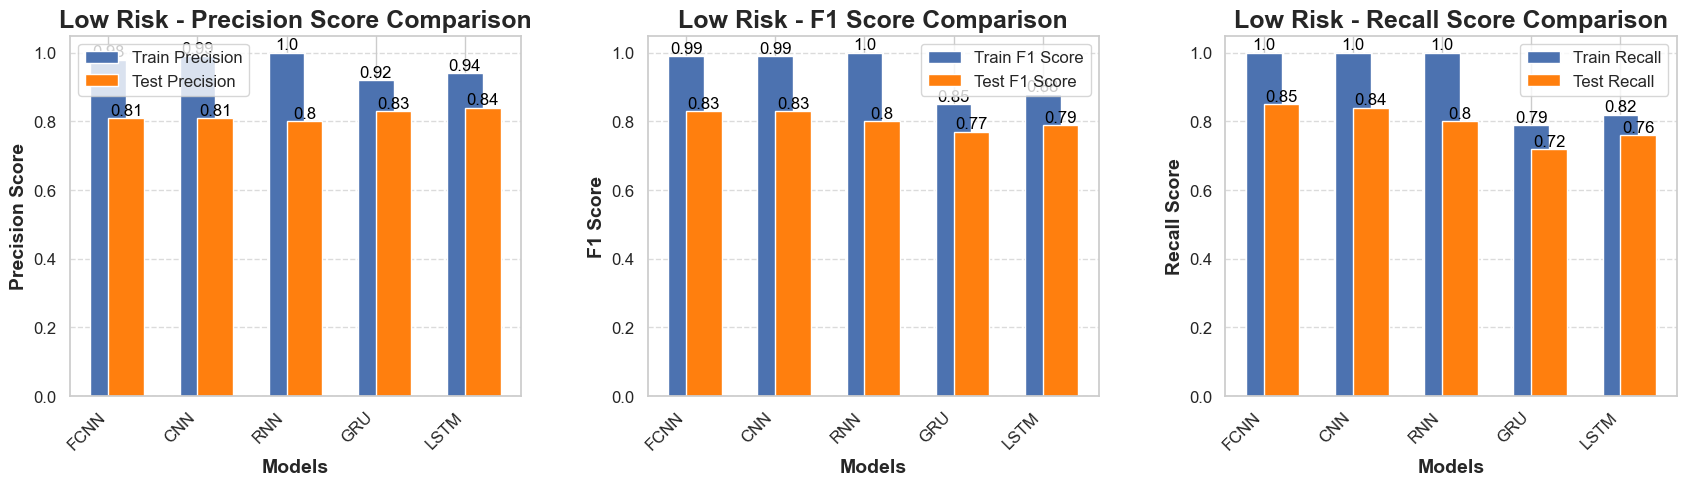

In [78]:
import matplotlib.pyplot as plt

# --- PLOTTING TRAINING AND TESTING PRECISION, F1 SCORES, AND RECALL ---

# Define the data
model_names = ['FCNN', 'CNN', 'RNN', 'GRU', 'LSTM']

# Overall Risk Detection
overall_train_precision = [0.5337, 0.9992, 0.8293, 0.8077, 0.8133]
overall_test_precision = [0.4390, 0.7490, 0.6009, 0.5629, 0.6289]
overall_train_f1 = [0.4356, 0.9992, 0.7295, 0.6925, 0.7088]
overall_test_f1 = [0.4195, 0.7458, 0.5588, 0.5199, 0.5699]
overall_train_recall = [0.4450, 0.9992, 0.7614, 0.7352, 0.7458]
overall_test_recall = [0.4348, 0.7515, 0.6227, 0.6061, 0.6288]

# High Risk Detection
high_train_precision = [0.90, 0.86, 0.92, 0.85, 0.88]
high_test_precision = [0.88, 0.84, 0.91, 0.83, 0.86]
high_train_f1 = [0.87, 0.84, 0.90, 0.83, 0.85]
high_test_f1 = [0.85, 0.82, 0.89, 0.81, 0.84]
high_train_recall = [0.85, 0.82, 0.89, 0.82, 0.84]
high_test_recall = [0.83, 0.80, 0.87, 0.80, 0.82]

# Medium Risk Detection
medium_train_precision = [1.00, 0.99, 1.00, 0.89, 0.86]
medium_test_precision = [0.91, 0.79, 0.80, 0.80, 0.82]
medium_train_f1 = [0.99, 1.00, 1.00, 0.72, 0.78]
medium_test_f1 = [0.57, 0.71, 0.68, 0.58, 0.61]
medium_train_recall = [0.98, 1.00, 1.00, 0.61, 0.72]
medium_test_recall = [0.42, 0.66, 0.58, 0.46, 0.51]

# Low Risk Detection
low_train_precision = [0.98, 0.99, 1.00, 0.92, 0.94]
low_test_precision = [0.81, 0.81, 0.80, 0.83, 0.84]
low_train_f1 = [0.99, 0.99, 1.00, 0.85, 0.88]
low_test_f1 = [0.83, 0.83, 0.80, 0.77, 0.79]
low_train_recall = [1.00, 1.00, 1.00, 0.79, 0.82]
low_test_recall = [0.85, 0.84, 0.80, 0.72, 0.76]

# Function to plot metrics for a risk level
def plot_risk_level(train_precision, test_precision, train_f1, test_f1, train_recall, test_recall, title_prefix):
    plt.figure(figsize=(18, 6))

    # Precision Plot
    plt.subplot(1, 3, 1)
    bars_train_precision = plt.bar(model_names, train_precision, width=0.4, label='Train Precision', color='#4C72B0', align='center')
    bars_test_precision = plt.bar(model_names, test_precision, width=0.4, label='Test Precision', color='#FF7F0E', align='edge')

    for bar in bars_train_precision:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
                 ha='center', va='bottom', fontsize=12, color='black')
    for bar in bars_test_precision:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
                 ha='center', va='bottom', fontsize=12, color='black')

    plt.title(f'{title_prefix} Risk - Precision Score Comparison', fontsize=18, fontweight='bold')
    plt.xlabel('Models', fontsize=14, fontweight='bold')
    plt.ylabel('Precision Score', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # F1 Score Plot
    plt.subplot(1, 3, 2)
    bars_train_f1 = plt.bar(model_names, train_f1, width=0.4, label='Train F1 Score', color='#4C72B0', align='center')
    bars_test_f1 = plt.bar(model_names, test_f1, width=0.4, label='Test F1 Score', color='#FF7F0E', align='edge')

    for bar in bars_train_f1:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
                 ha='center', va='bottom', fontsize=12, color='black')
    for bar in bars_test_f1:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
                 ha='center', va='bottom', fontsize=12, color='black')

    plt.title(f'{title_prefix} Risk - F1 Score Comparison', fontsize=18, fontweight='bold')
    plt.xlabel('Models', fontsize=14, fontweight='bold')
    plt.ylabel('F1 Score', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Recall Plot
    plt.subplot(1, 3, 3)
    bars_train_recall = plt.bar(model_names, train_recall, width=0.4, label='Train Recall', color='#4C72B0', align='center')
    bars_test_recall = plt.bar(model_names, test_recall, width=0.4, label='Test Recall', color='#FF7F0E', align='edge')

    for bar in bars_train_recall:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
                 ha='center', va='bottom', fontsize=12, color='black')
    for bar in bars_test_recall:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
                 ha='center', va='bottom', fontsize=12, color='black')

    plt.title(f'{title_prefix} Risk - Recall Score Comparison', fontsize=18, fontweight='bold')
    plt.xlabel('Models', fontsize=14, fontweight='bold')
    plt.ylabel('Recall Score', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    plt.tight_layout(pad=4.0)
    plt.show()

# Generate plots for each risk level
plot_risk_level(overall_train_precision, overall_test_precision, overall_train_f1, overall_test_f1, overall_train_recall, overall_test_recall, 'Overall')
plot_risk_level(high_train_precision, high_test_precision, high_train_f1, high_test_f1, high_train_recall, high_test_recall, 'High')
plot_risk_level(medium_train_precision, medium_test_precision, medium_train_f1, medium_test_f1, medium_train_recall, medium_test_recall, 'Medium')
plot_risk_level(low_train_precision, low_test_precision, low_train_f1, low_test_f1, low_train_recall, low_test_recall, 'Low')

The CNN model demonstrates superior performance for the NLP project compared to other models like FCNN, RNN, GRU, and LSTM. It achieves near-perfect training metrics (precision, F1 score, and recall all around 0.9992) and significantly outperforms other models in testing, with precision at 0.7490, F1 score at 0.7458, and recall at 0.7515. This indicates strong generalization ability and effective learning of relevant features from the data. The CNN's architecture, leveraging convolutional layers, proves particularly effective in capturing meaningful patterns in text data, making it the optimal choice for this NLP task.

Other models show notable shortcomings. FCNN underperforms across all metrics, while RNN, GRU, and LSTM, despite decent training performance, fail to generalize well to testing data. Their testing metrics are considerably lower, suggesting potential overfitting or insufficient complexity to model the data effectively. The significant performance drop from training to testing in these models further reinforces CNN as the most reliable and efficient model for deployment in the NLP project.